# HAT Substrate Comparison — Neutral vs Emotional

Compare **Hardware Anomaly Traces (HAT)** of a Llama-2-7B inference server
across two prompt conditions: **neutral** (WikiHow) vs **emotional** (Creepypasta).

The HAT (§4.2.2) has two layers:
- **Layer 1** — Hardware Anomaly Interrupts: spurious, MCE, NMI/PMI, thermal/power, TLB shootdown
- **Layer 2** — Continuous metrics: cache hit rates, power consumption, thermal, memory access entropy, clock cycles

**Data per run** (produced by `substrate_collector.py`):

| File | Resolution | Content |
|------|------------|---------|
| `perf_stat.csv` | 1 ms buckets | 24 perf events: HAT L1 tracepoints + HAT L2 PMU/power + supporting confounders |
| `proc_sample.csv` | 200 ms | Per-process CPU + RSS for llama.cpp container |
| `hat_interrupts.csv` | 200 ms | /proc/interrupts (SPU, NMI, PMI, MCE, TLB), /proc/softirqs, CPU freq |
| `kernel_log.txt` | per run | dmesg slice — MCE records, thermal events, hardware errors |
| `responses.jsonl` | per request | LLM timing + tokens evaluated/predicted |

In [50]:
import re, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 4)

## 1 — Configuration

In [51]:
BASE_DIR = Path.home() / 'Desktop' / 'mccviahat' 

NEUTRAL_RUN   = 'runs/NEWTrainingN'
EMOTIONAL_RUN = 'runs/NEWTrainingE'

n_dir = BASE_DIR / NEUTRAL_RUN
e_dir = BASE_DIR / EMOTIONAL_RUN

for d in [n_dir, e_dir]:
    assert d.exists(), f'Missing: {d}'
print('Both run directories found')

Both run directories found


## 2 — Loaders

`perf_stat.csv` is already in wide format (one row per ms, one column per event) —
produced by the collector's post-processing step. No parsing needed.

In [52]:
def load_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding='utf-8'))


def load_perf(run_dir: Path) -> pd.DataFrame:
    """Load perf_stat.csv (wide format: t_s, event1, event2, ...)."""
    csv_path = run_dir / 'perf_stat.csv'
    if csv_path.exists():
        return pd.read_csv(csv_path)
    # Fallback: parse perf_stat.txt (handles both -x ',' CSV and legacy human-readable)
    return _parse_perf_stat_legacy(run_dir / 'perf_stat.txt')


def _parse_perf_stat_legacy(path: Path) -> pd.DataFrame:
    """Parse perf stat output — auto-detects -x ',' CSV vs old human-readable format."""
    text = path.read_text(encoding='utf-8', errors='replace')
    lines = text.splitlines()

    # Detect format: -x ',' CSV lines look like "0.001089231,5,,irq:irq_handler_entry,..."
    # Human-readable lines look like "     0.001   5   irq:irq_handler_entry  # ..."
    sample_lines = [l.strip() for l in lines[:50] if l.strip() and not l.strip().startswith('#')]
    is_csv = any(',' in l and len(l.split(',')) >= 4 for l in sample_lines)

    from collections import OrderedDict
    rows_by_ts = OrderedDict()
    events_seen = []

    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            continue

        if is_csv:
            # -x ',' format: timestamp,value,unit,event,runtime,pct,...
            parts = line.split(',')
            if len(parts) < 4:
                continue
            ts_str = parts[0].strip()
            val_str = parts[1].strip()
            event = parts[3].strip()
            if not event:
                continue
            try:
                ts = float(ts_str)
            except ValueError:
                continue
            if val_str.startswith('<') or val_str == '':
                val = np.nan
            else:
                try:
                    val = float(val_str)
                except ValueError:
                    val = np.nan
        else:
            # Legacy human-readable format
            parts = line.split('#', 1)
            tokens = parts[0].strip().split()
            if len(tokens) < 3:
                continue
            try:
                ts = float(tokens[0])
            except ValueError:
                continue
            event = tokens[-1]
            raw_val = tokens[1].replace(',', '')
            val = float(raw_val) if not raw_val.startswith('<') else np.nan

        if event not in events_seen:
            events_seen.append(event)
        if ts not in rows_by_ts:
            rows_by_ts[ts] = {}
        rows_by_ts[ts][event] = val

    # Build wide-format DataFrame
    records = []
    for ts, evts in rows_by_ts.items():
        row = {'t_s': ts}
        for evt in events_seen:
            row[evt] = evts.get(evt, np.nan)
        records.append(row)

    df = pd.DataFrame(records)
    if len(df) > 0:
        df = df.sort_values('t_s').reset_index(drop=True)
    print(f'  Parsed {path.name}: {len(df):,} rows × {len(events_seen)} events')
    return df


def load_responses(run_dir: Path) -> pd.DataFrame:
    """Load responses.jsonl and extract llama.cpp timings."""
    rows = []
    for line in (run_dir / 'responses.jsonl').read_text(encoding='utf-8').splitlines():
        if not line.strip():
            continue
        r = json.loads(line)
        try:
            resp = json.loads(r['response_raw'])
            timings = resp.get('timings', {})
            r['prompt_ms']         = timings.get('prompt_ms')
            r['predicted_ms']      = timings.get('predicted_ms')
            r['tokens_evaluated']  = resp.get('tokens_evaluated')
            r['tokens_predicted']  = resp.get('tokens_predicted')
        except Exception:
            pass
        rows.append(r)
    df = pd.DataFrame(rows)
    keep = [c for c in ['id', 'title', 'ok', 't_request_start_ns', 't_request_end_ns',
                         'prompt_ms', 'predicted_ms', 'tokens_evaluated', 'tokens_predicted']
            if c in df.columns]
    df = df[keep].sort_values('t_request_start_ns').reset_index(drop=True)
    df['duration_s'] = (df['t_request_end_ns'] - df['t_request_start_ns']) / 1e9
    return df


def load_hat_interrupts(run_dir: Path) -> pd.DataFrame:
    """Load hat_interrupts.csv (or legacy proc_system_sample.csv)."""
    hat_path = run_dir / 'hat_interrupts.csv'
    legacy_path = run_dir / 'proc_system_sample.csv'
    path = hat_path if hat_path.exists() else legacy_path
    df = pd.read_csv(path)
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    return df


def load_proc_sample(run_dir: Path) -> pd.DataFrame:
    df = pd.read_csv(run_dir / 'proc_sample.csv')
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    return df

## 3 — Load data

In [53]:
n_cmeta = load_json(n_dir / 'collector_meta.json')
e_cmeta = load_json(e_dir / 'collector_meta.json')

n_resp = load_responses(n_dir)
e_resp = load_responses(e_dir)

n_perf = load_perf(n_dir)
e_perf = load_perf(e_dir)

n_hat = load_hat_interrupts(n_dir)
e_hat = load_hat_interrupts(e_dir)

n_proc = load_proc_sample(n_dir)
e_proc = load_proc_sample(e_dir)

n_meta = load_json(n_dir / 'meta.json')
e_meta = load_json(e_dir / 'meta.json')

# Derive common events (columns present in both perf DataFrames, minus t_s)
common_events = sorted(set(n_perf.columns) & set(e_perf.columns) - {'t_s'})

print(f'Perf events ({len(common_events)}): {common_events}')
print(f'Perf rows   — neutral: {len(n_perf):,}   emotional: {len(e_perf):,}')
print(f'Responses   — neutral: {len(n_resp)}   emotional: {len(e_resp)}')
print(f'Run duration — neutral: {n_perf["t_s"].max():.0f}s   emotional: {e_perf["t_s"].max():.0f}s')

Perf events (25): ['LLC-load-misses', 'branch-instructions', 'branch-misses', 'cache-misses', 'cache-references', 'context-switches', 'core_power.throttle', 'cpu-clock', 'cpu-migrations', 'cycles', 'dTLB-load-misses', 'instructions', 'irq:irq_handler_entry', 'irq:irq_handler_exit', 'irq:softirq_entry', 'irq:softirq_exit', 'irq:softirq_raise', 'mce:mce_record', 'msr/cpu_thermal_margin/', 'page-faults', 'power/energy-pkg/', 'power/energy-ram/', 'stalled-cycles-backend', 'stalled-cycles-frontend', 'tlb:tlb_flush']
Perf rows   — neutral: 46,635   emotional: 46,221
Responses   — neutral: 20   emotional: 20
Run duration — neutral: 353s   emotional: 348s


## 4 — Request timing

Each prompt is sent sequentially. `tokens_evaluated` reflects prompt length (input),
`tokens_predicted` is fixed at 50 (`n_predict=50`). `duration_s` is the wall-clock
time for one request — this becomes `window_duration_s` in later feature extraction.

In [54]:
show_cols = ['id', 'title', 'duration_s', 'tokens_evaluated', 'tokens_predicted', 'prompt_ms', 'predicted_ms']
print(f'=== Neutral ({len(n_resp)}/{20} completed) ===')
display(n_resp[show_cols])
print(f'\n=== Emotional ({len(e_resp)}/{20} completed) ===')
display(e_resp[show_cols])

=== Neutral (20/20 completed) ===


,id,title,duration_s,tokens_evaluated,tokens_predicted,prompt_ms,predicted_ms
0,1,How to Raise a Perfect Garchomp,17.412121,699,50,10195.257,7201.859
1,2,How to Create Glow in the Dark Log Campfire St...,16.492050,610,50,9102.239,7376.057
2,3,How to Eat Honeycomb,18.673010,758,50,11029.661,7630.415
3,4,How to Make Your Own Skin in Minecraft,17.390813,634,50,9537.660,7839.173
4,5,How to Learn a Piano Piece Quickly,16.229810,557,50,8202.526,7458.818
5,6,How to Make Medical Marijuana Brownies,17.555722,627,50,9227.618,7827.973
6,7,How to Make Waterproof Matches,17.559617,619,50,9151.100,7810.997
7,8,How to Write a Speech if You're Third Speaker,15.871350,560,50,8208.099,7309.811
8,9,How to Create a Hot Compress for Acne Treatmen...,17.403157,659,50,9562.758,7526.212
9,10,How to Clean Tennis Balls,16.662302,600,50,8826.854,7488.530



=== Emotional (20/20 completed) ===


,id,title,duration_s,tokens_evaluated,tokens_predicted,prompt_ms,predicted_ms
0,1,Stairs,16.103296,635,50,9326.837,6760.754
1,2,The Kaleidoscope,16.831021,616,50,9340.437,7478.399
2,3,I Told You To Smile,16.732095,626,50,9218.013,7502.090
3,4,Tower of Silence,16.484089,593,50,8793.028,7678.544
4,5,The Boogey Man,17.112263,619,50,9055.311,7554.846
5,6,The Window,16.484054,579,50,8511.948,7481.120
6,7,Branches in the Wind,18.480699,702,50,10340.173,7796.864
7,8,Hope,17.141480,587,50,8761.301,7731.978
8,9,Where Bad Kids Go,17.459990,633,50,9162.028,7614.006
9,10,Lazy Saturday Night,18.370350,700,50,10221.973,7650.293


## 5 — Perf event overview

Mean event count per 1 ms bucket across the entire run. This is a first look —
if the means differ, the time-series and per-request features (§6) will tell us more.

In [55]:
common_events = sorted(set(n_perf.columns) & set(e_perf.columns) - {'t_s'})
print(f'Events in both runs ({len(common_events)}):\n')
print(f'{"Event":35s}  {"Neutral mean":>14s}  {"Emotional mean":>14s}')
print('-' * 68)
for e in common_events:
    print(f'{e:35s}  {n_perf[e].mean():14.2f}  {e_perf[e].mean():14.2f}')

Events in both runs (25):

Event                                  Neutral mean  Emotional mean
--------------------------------------------------------------------
LLC-load-misses                           298812.93       298778.64
branch-instructions                     14006143.25     14001299.91
branch-misses                             372644.60       368873.22
cache-misses                             1847048.81      1851170.06
cache-references                         3474015.46      3443054.76
context-switches                            1203.74         1212.57
core_power.throttle                      3154428.15      3100751.19
cpu-clock                                    483.82          481.78
cpu-migrations                               218.76          220.70
cycles                                 276761947.32    276279476.62
dTLB-load-misses                           26619.70        26474.23
instructions                           426304073.92    422081741.58
irq:irq_handler_entr

## 6 — Time-series visualisation

Smoothed (rolling mean) time-series for key perf events. Shaded bands = request windows.
This helps spot obvious patterns (e.g. thermal drift, burst clusters) before formal testing.

In [56]:
def request_windows(resp, t0_ns):
    return [(float(r['t_request_start_ns'] - t0_ns) / 1e9,
             float(r['t_request_end_ns']   - t0_ns) / 1e9)
            for _, r in resp.iterrows()]

n_wins = request_windows(n_resp, n_cmeta['t0_ns'])
e_wins = request_windows(e_resp, e_cmeta['t0_ns'])

baseline_s = n_meta.get('baseline_s', 3.0)
run_dur_ms = max(n_perf['t_s'].max(), e_perf['t_s'].max()) * 1000
SMOOTH_MS = int(np.clip(run_dur_ms * 0.01, 500, 5000))


def plot_event(evt, smooth_ms=None):
    if smooth_ms is None:
        smooth_ms = SMOOTH_MS
    if evt not in n_perf.columns or evt not in e_perf.columns:
        print(f'  {evt} not in both runs — skipping.')
        return
    fig, axes = plt.subplots(1, 2, figsize=(14, 3.5), sharey=True)
    for ax, label, df, wins, color in [
        (axes[0], 'Neutral',   n_perf, n_wins, 'steelblue'),
        (axes[1], 'Emotional', e_perf, e_wins, 'firebrick'),
    ]:
        smoothed = df[evt].rolling(smooth_ms, min_periods=1).mean()
        ax.plot(df['t_s'], smoothed, color=color, lw=0.8, alpha=0.9)
        for s, e in wins:
            ax.axvspan(s, e, alpha=0.10, color=color)
        ax.axvline(baseline_s, ls=':', color='gray', lw=0.5)
        ax.set_title(f'{label} — {evt}')
        ax.set_xlabel('time (s)')
    axes[0].set_ylabel(f'rolling {smooth_ms}ms mean')
    plt.tight_layout()
    plt.show()

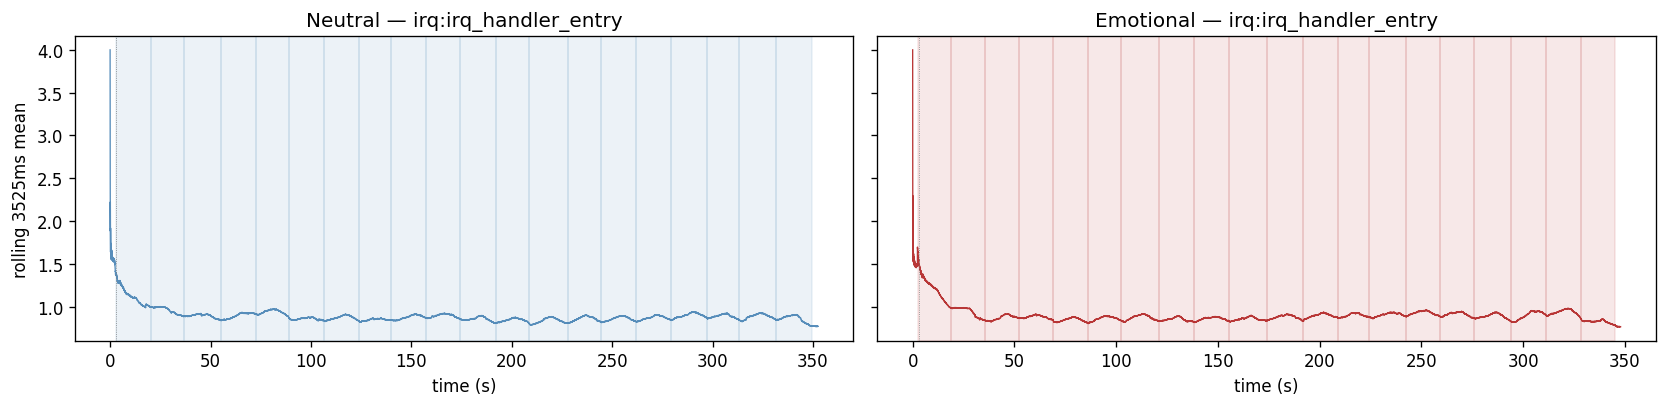

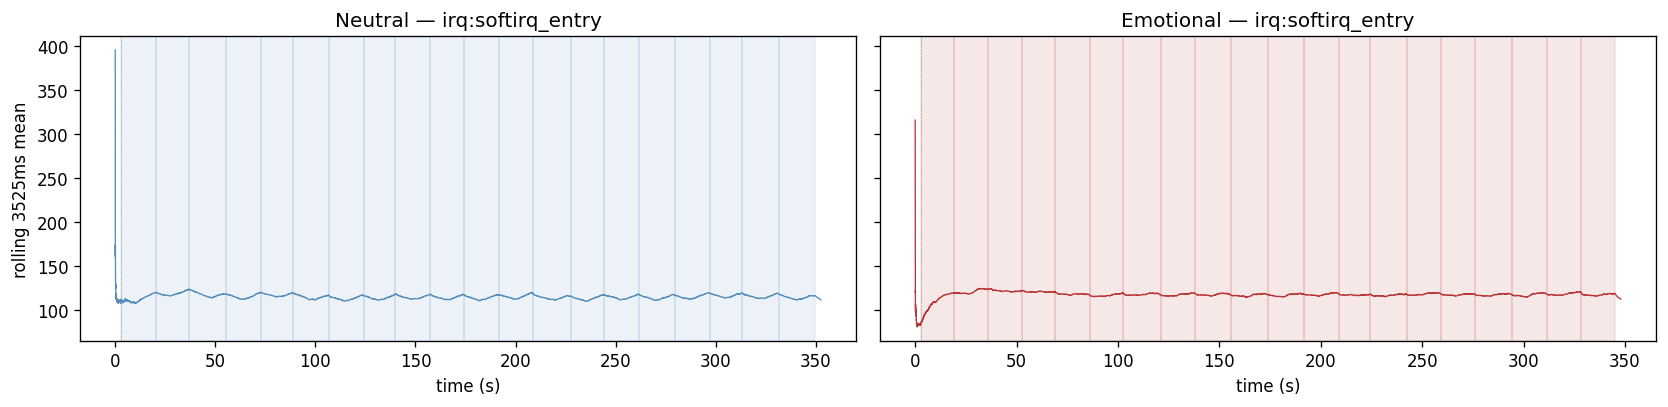

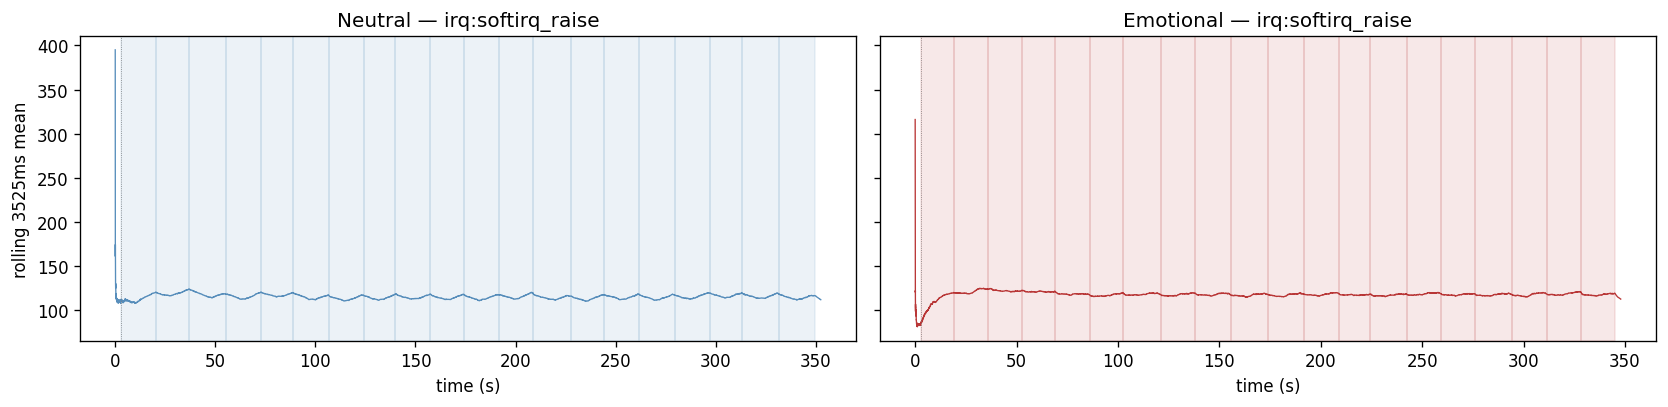

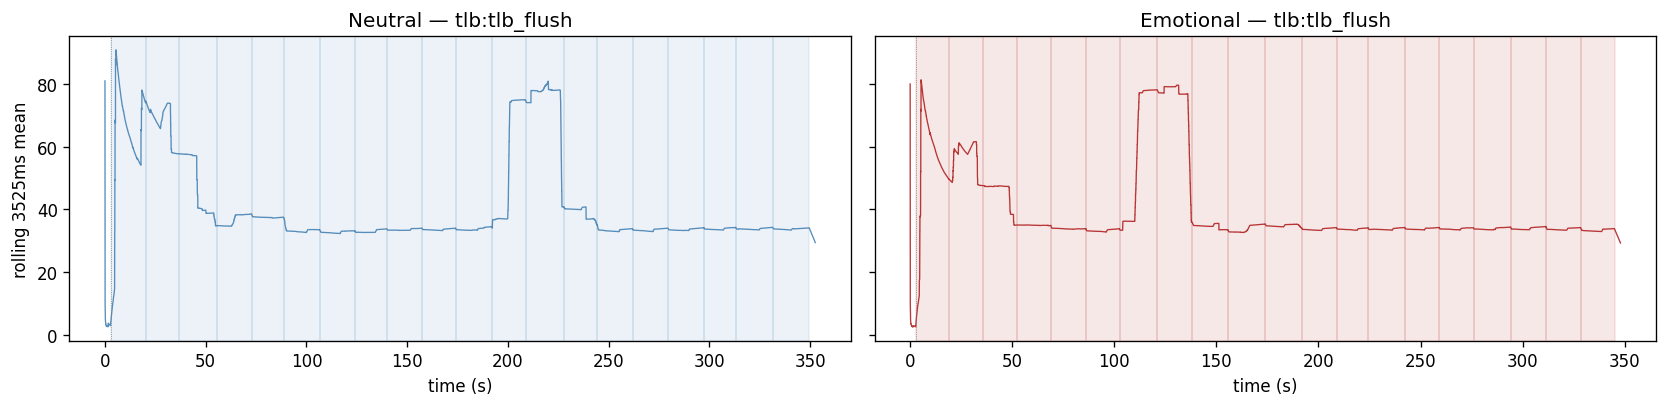

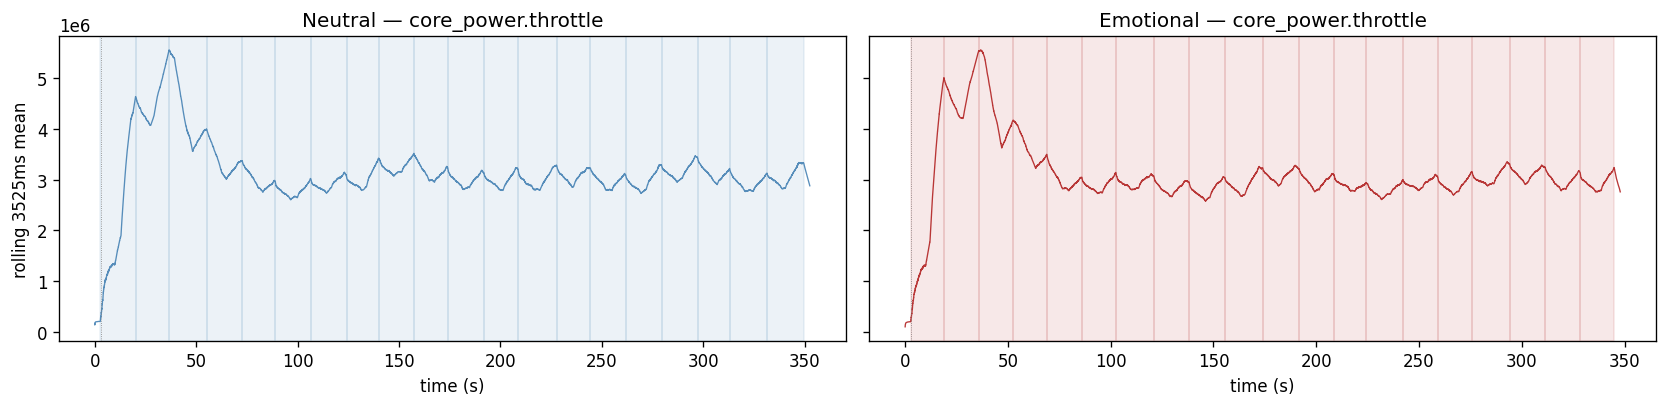

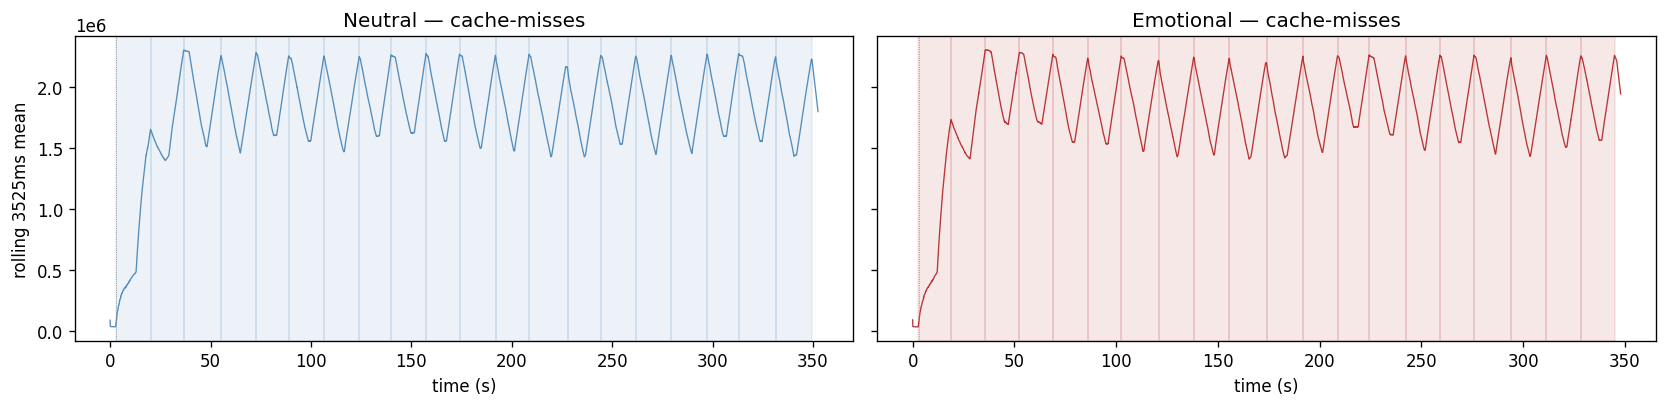

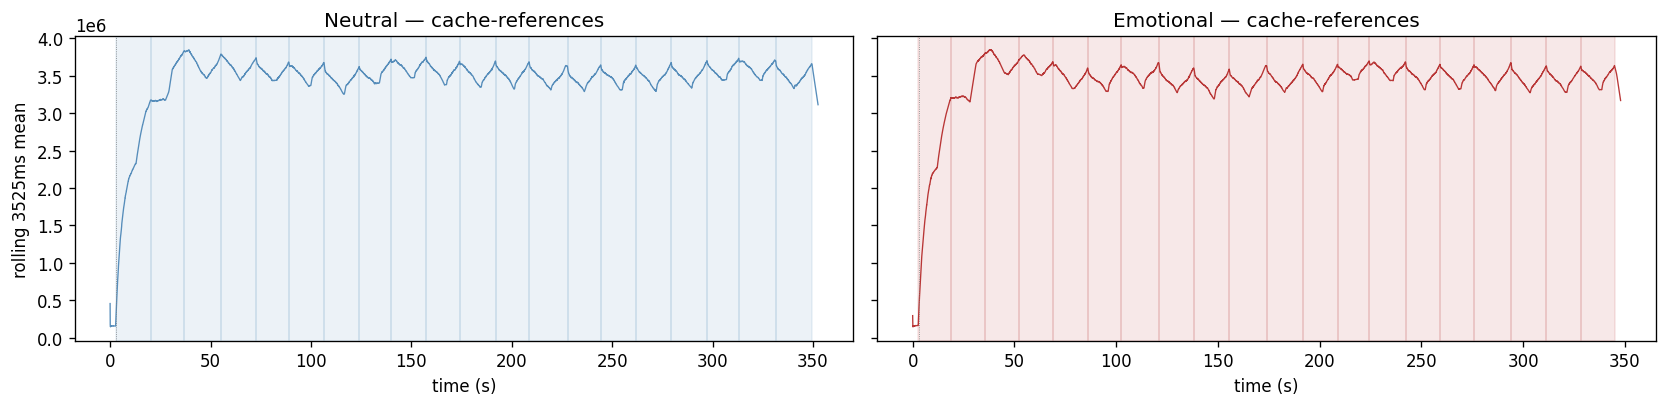

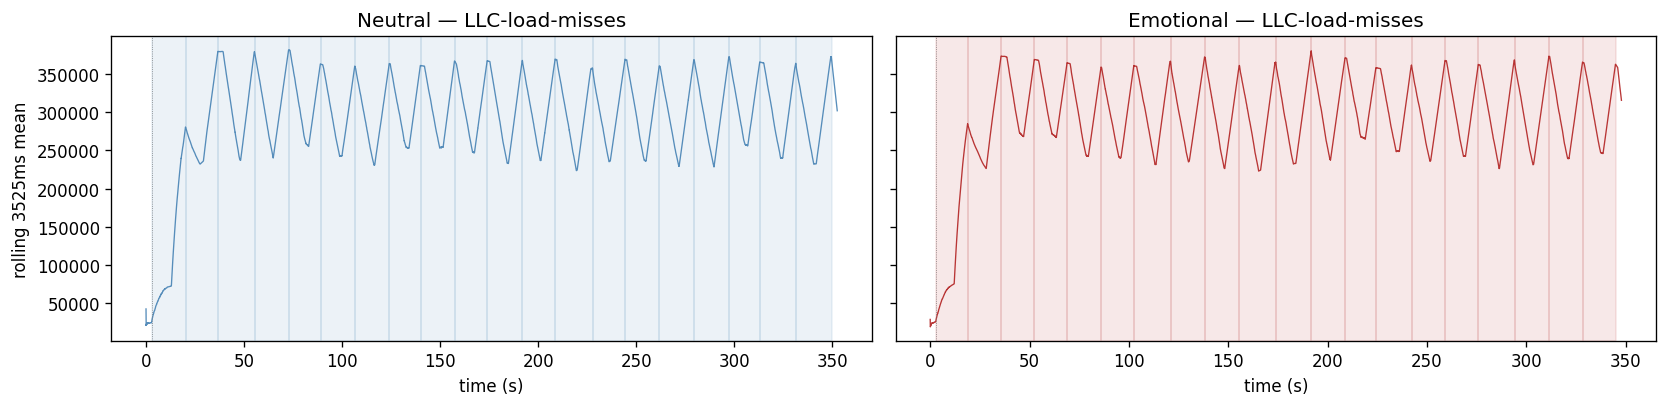

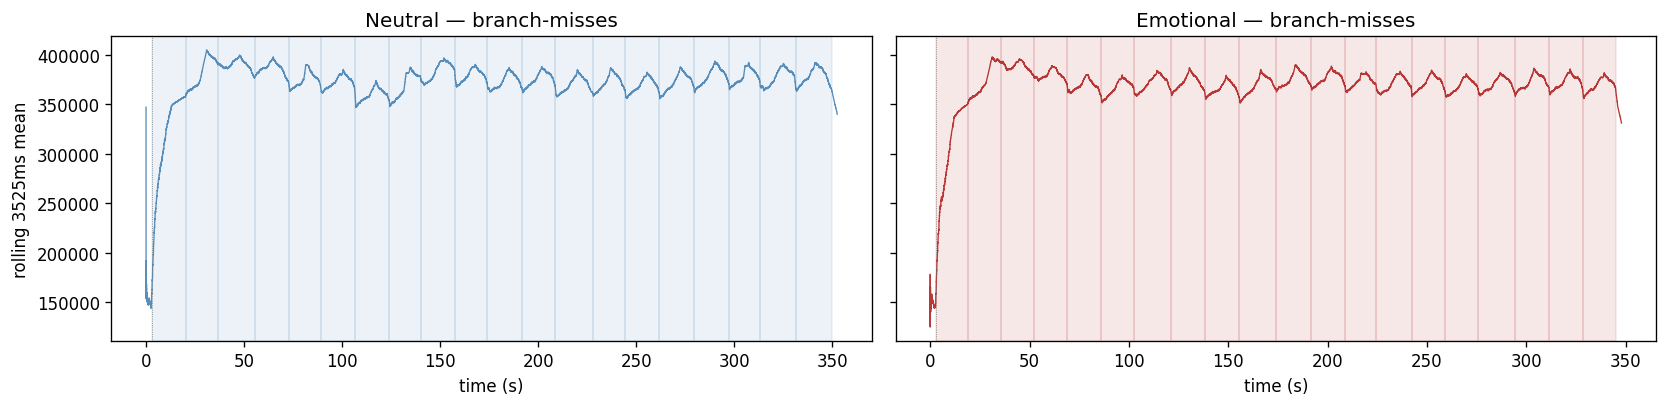

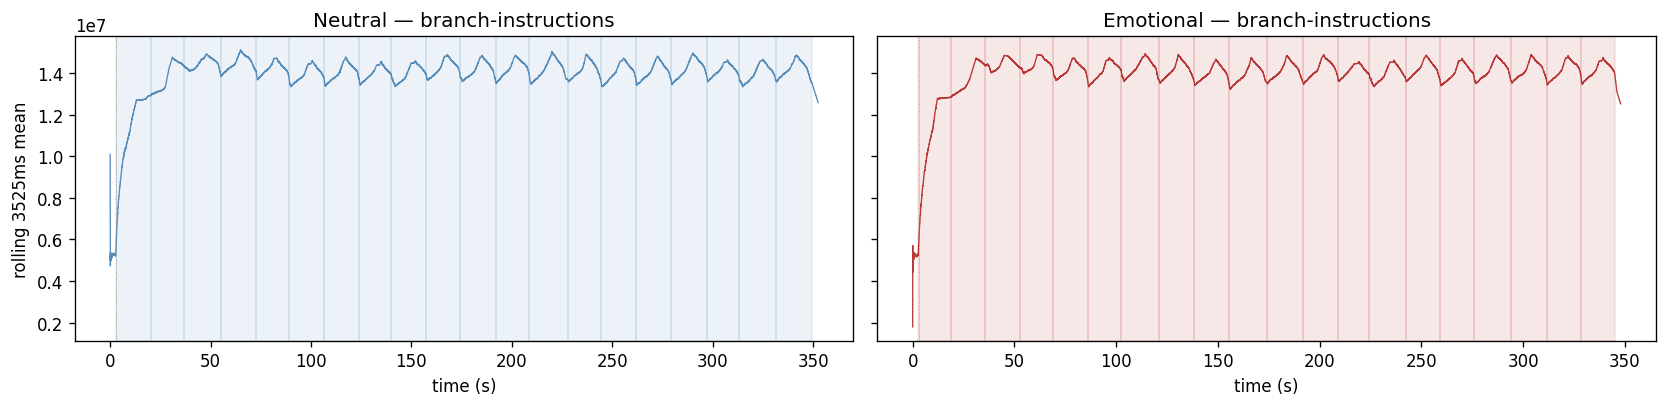

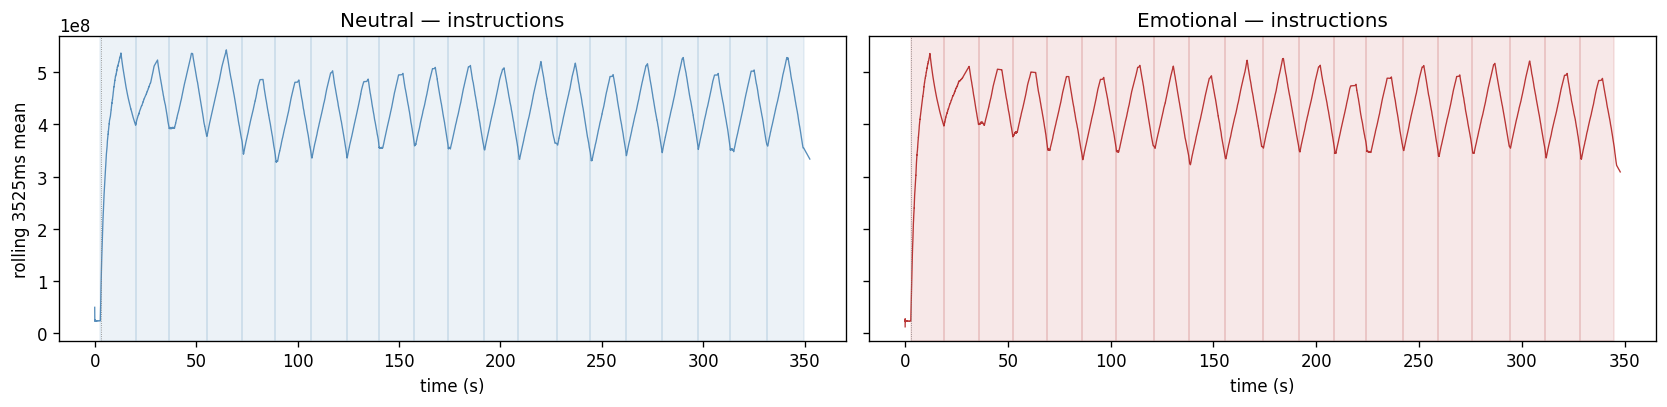

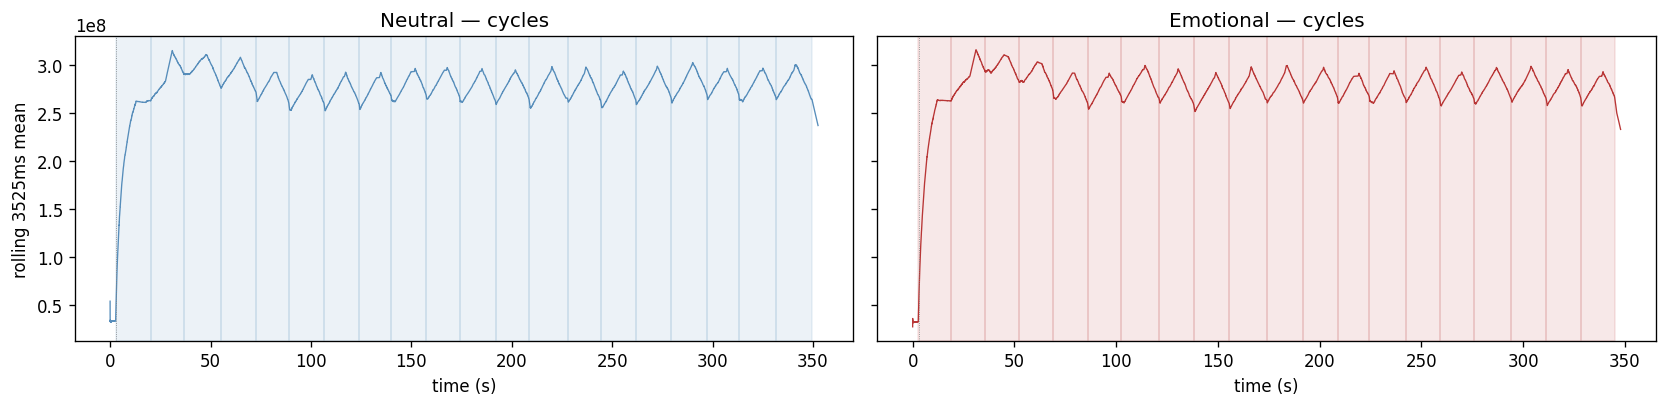

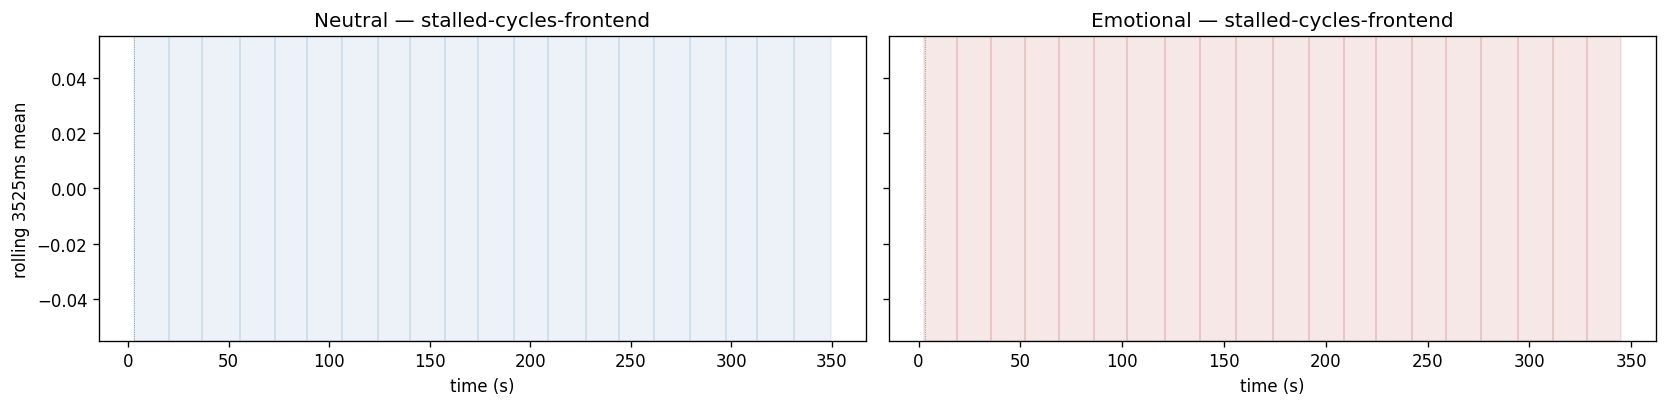

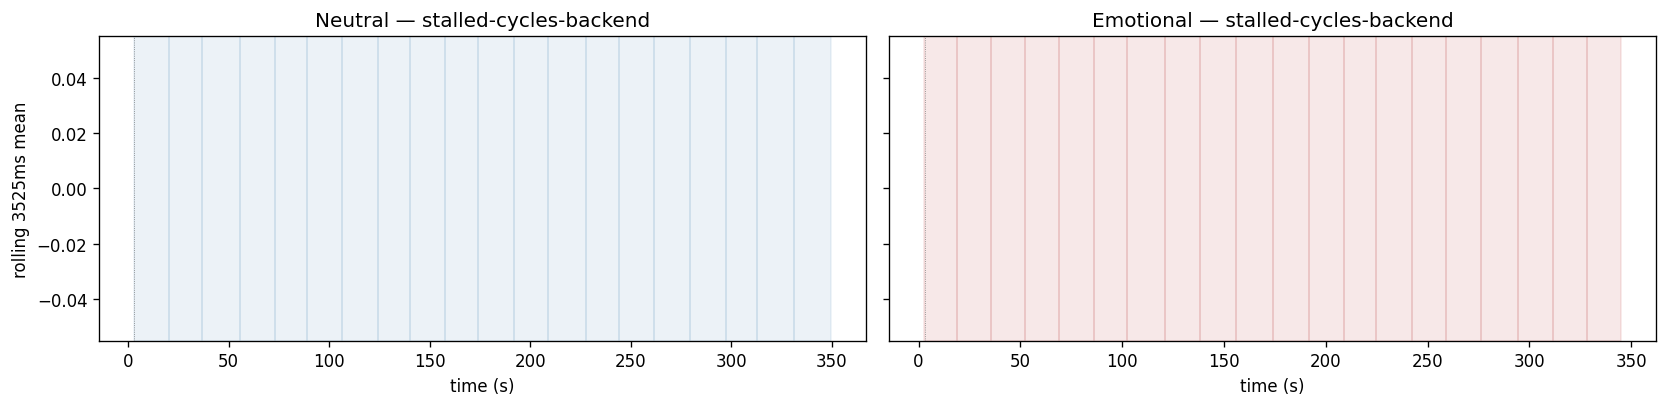

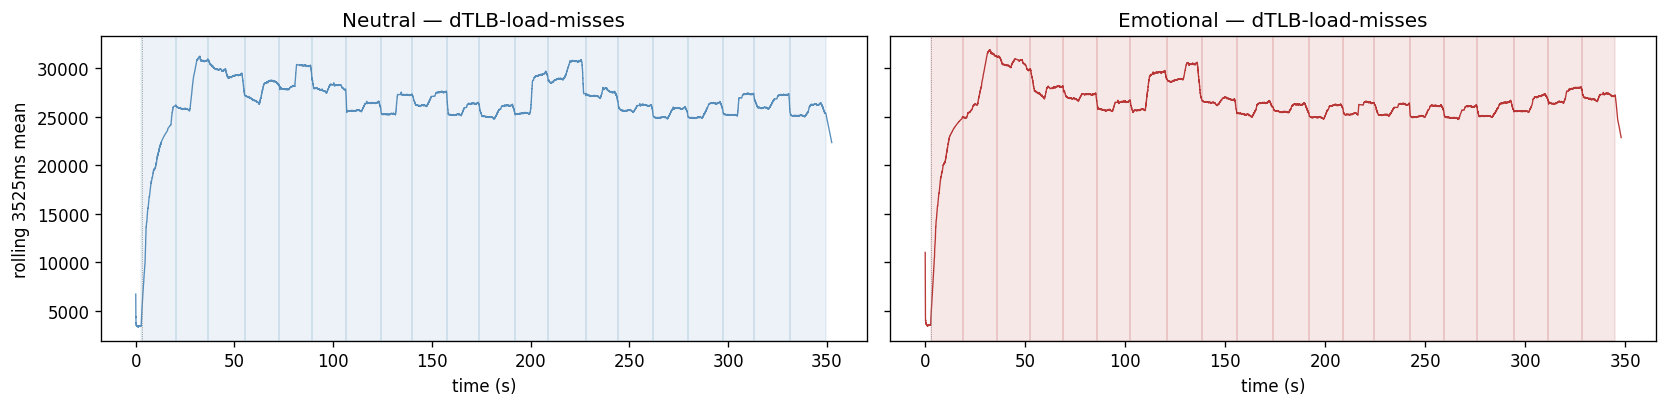

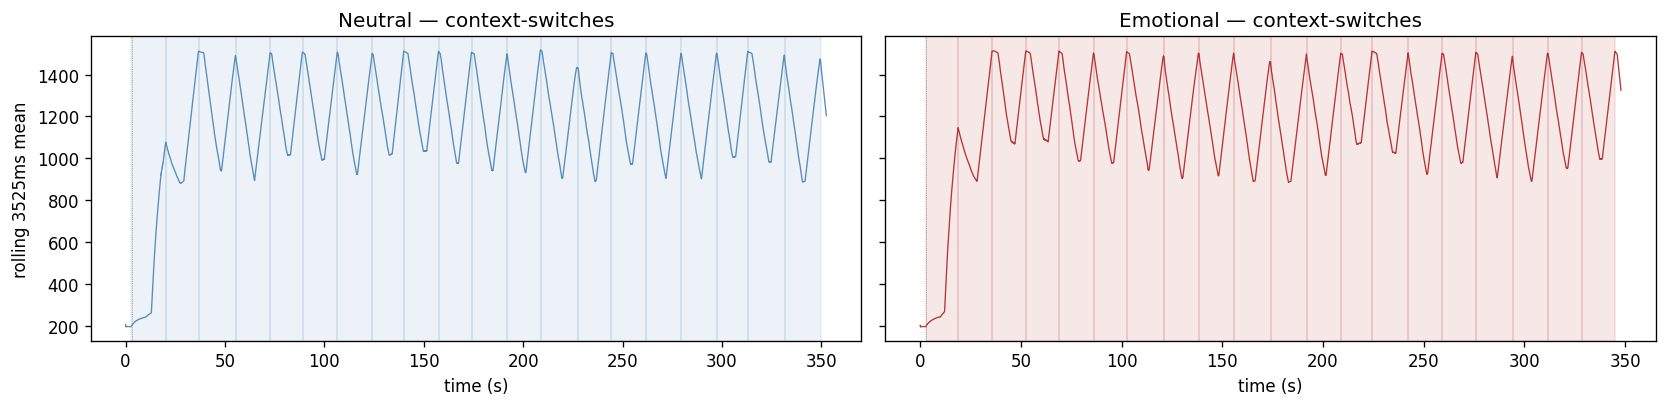

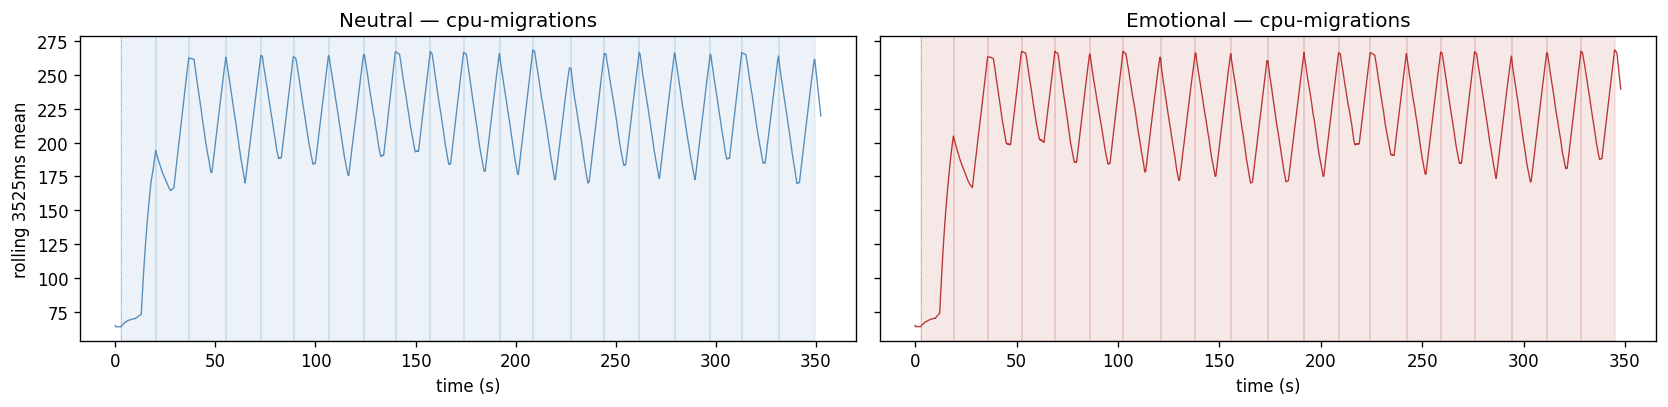

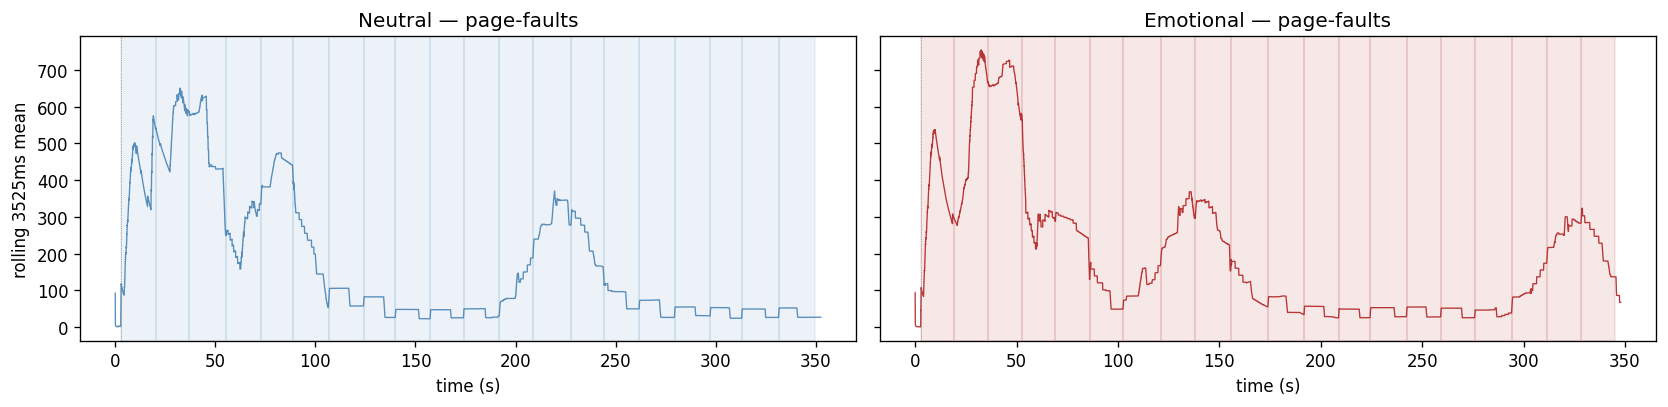

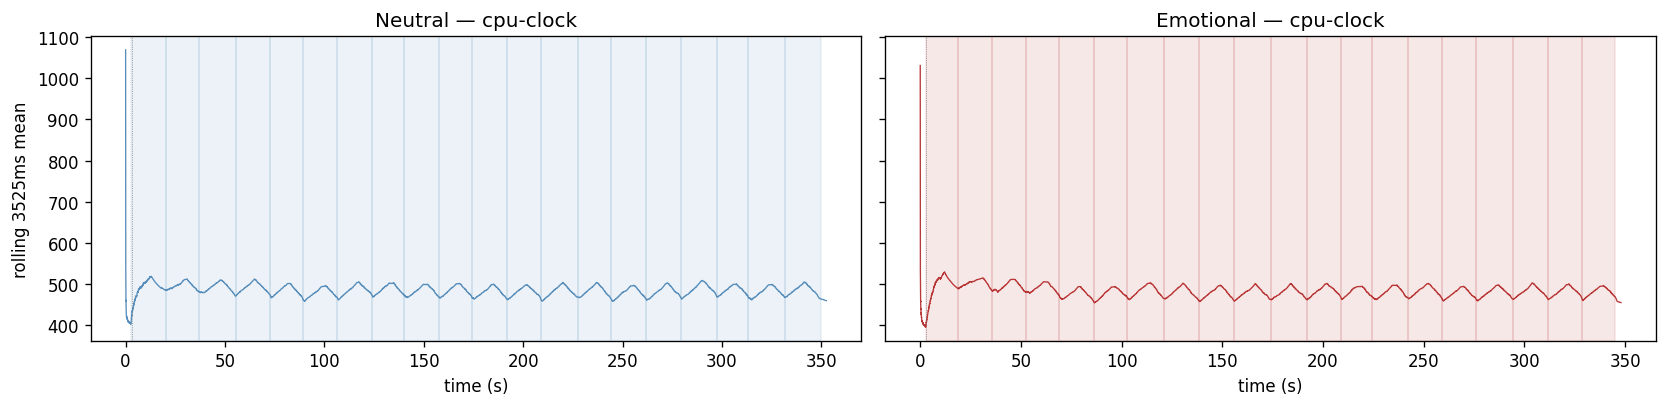

In [57]:
# HAT Layer 1 tracepoints
for evt in ['irq:irq_handler_entry', 'irq:softirq_entry', 'irq:softirq_raise',
            'tlb:tlb_flush', 'core_power.throttle']:
    plot_event(evt)

# HAT Layer 2 PMU hardware counters
for evt in ['cache-misses', 'cache-references', 'LLC-load-misses',
            'branch-misses', 'branch-instructions',
            'instructions', 'cycles',
            'stalled-cycles-frontend', 'stalled-cycles-backend',
            'dTLB-load-misses']:
    plot_event(evt)

# Supporting confounders
for evt in ['context-switches', 'cpu-migrations', 'page-faults', 'cpu-clock']:
    plot_event(evt)

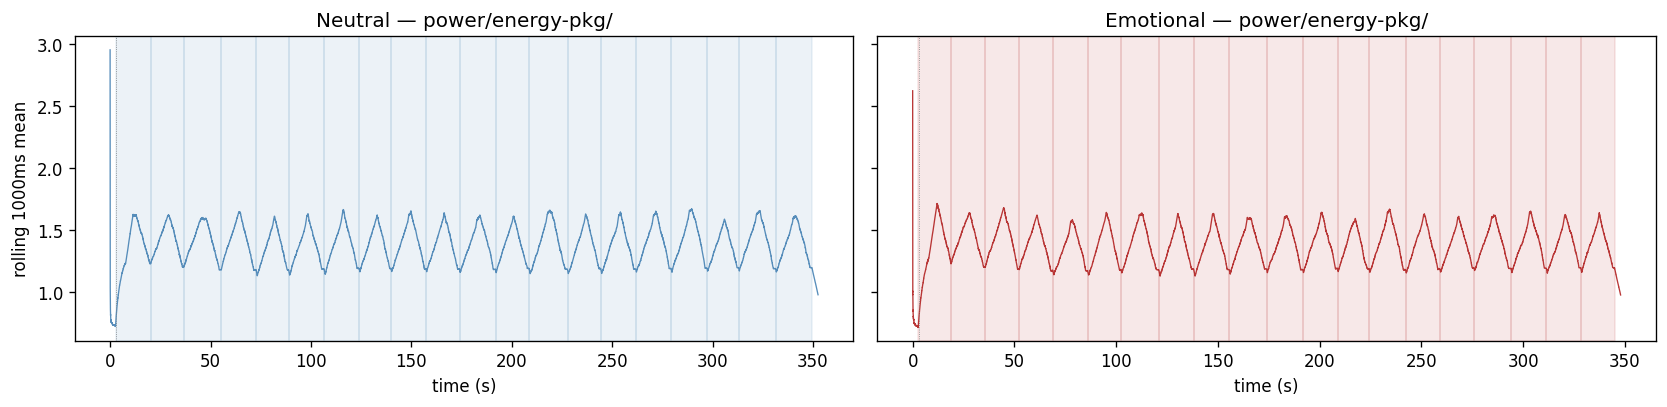

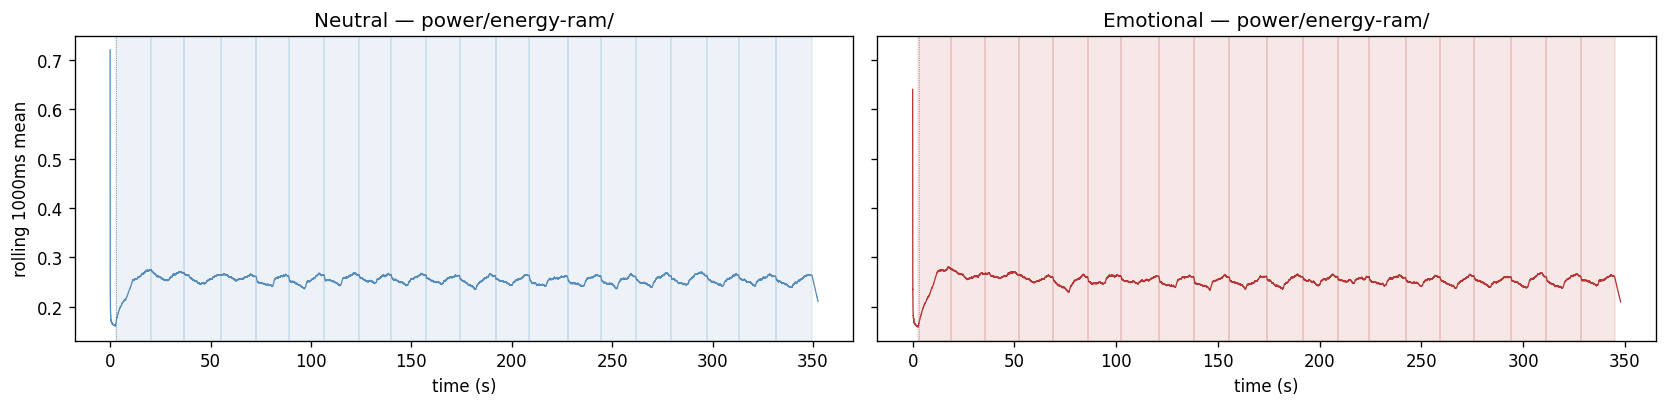

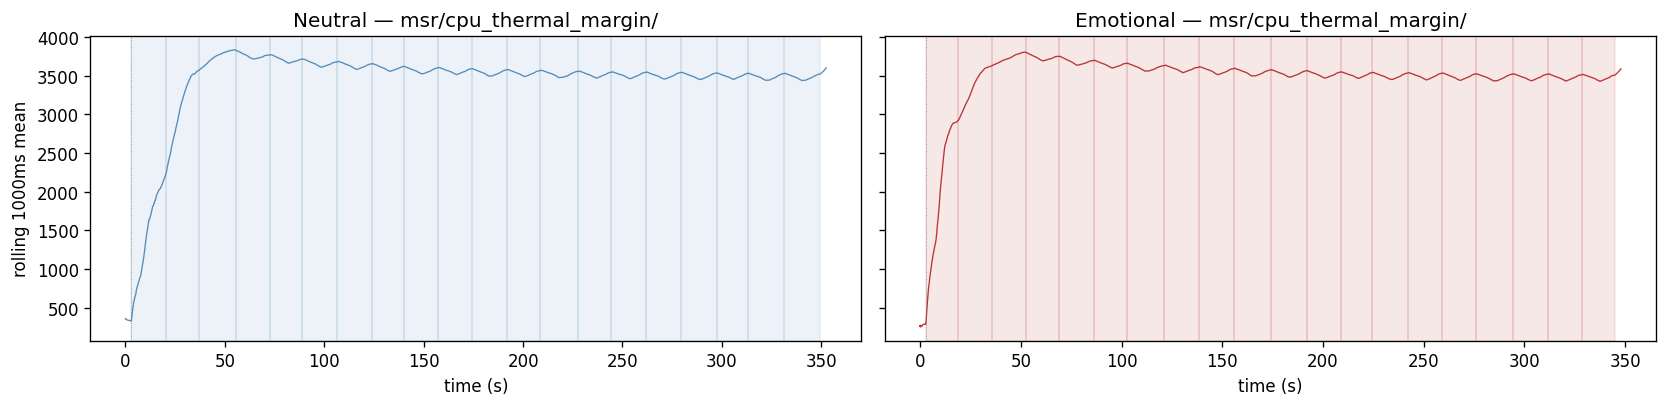

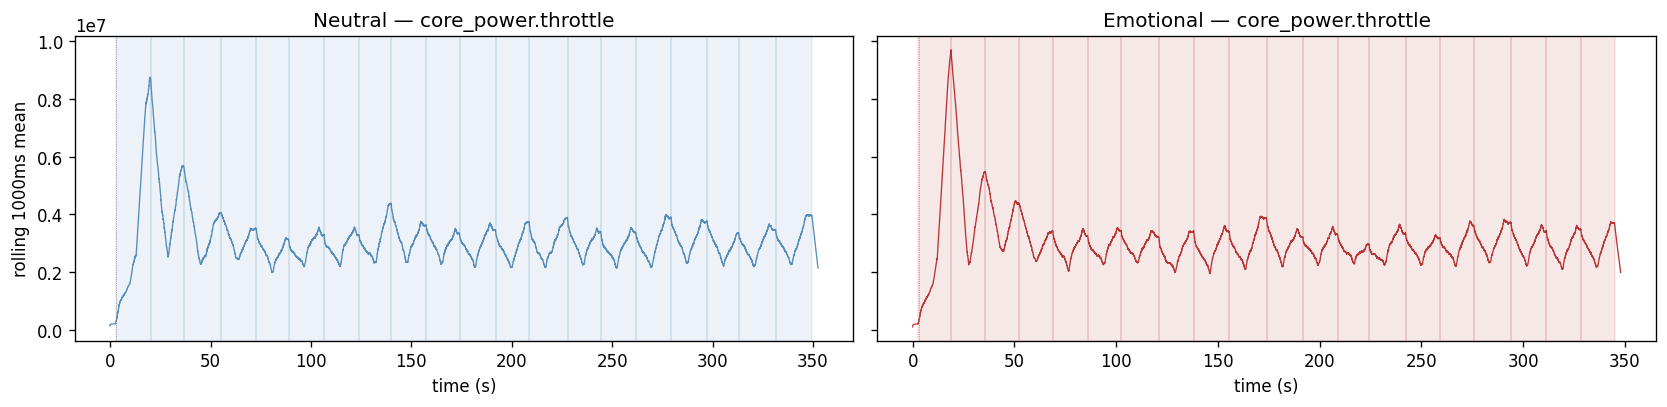

In [58]:
for evt in ['power/energy-pkg/', 'power/energy-ram/', 'msr/cpu_thermal_margin/', 'core_power.throttle']:
    plot_event(evt, smooth_ms=1000)

## 7 — Per-process CPU & /proc softirqs

`proc_sample.csv` tracks llama.cpp CPU jiffies at 200 ms. Differencing gives
approximate CPU utilisation per interval.

**Known issue:** The collector tracks the Docker exec wrapper PID, not the actual
llama-server process, so `proc_cpu_frac` may be inaccurate.

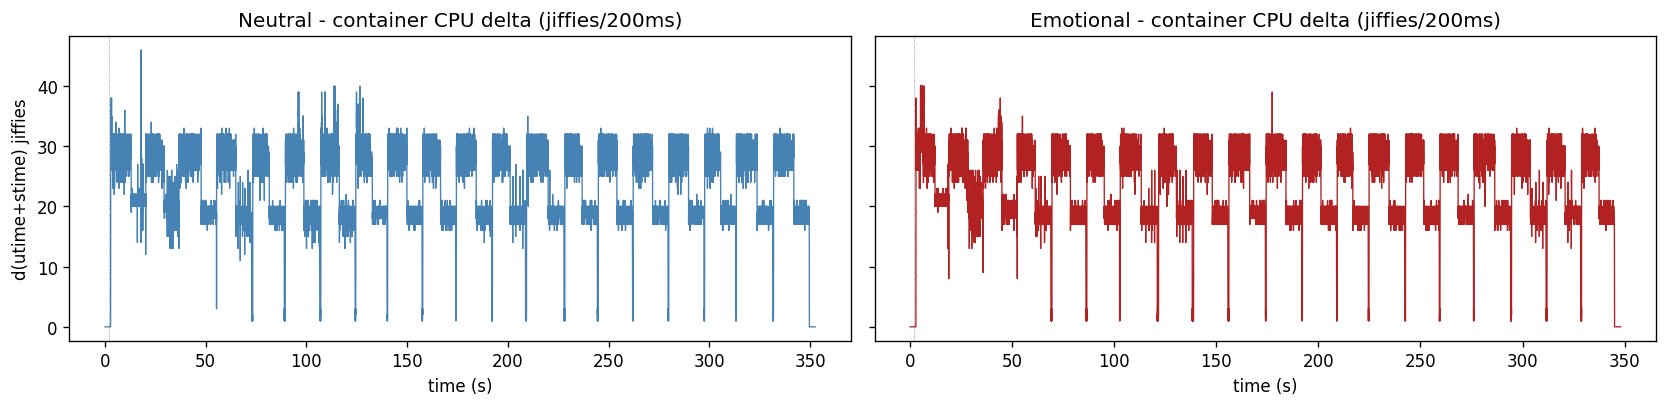

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3.5), sharey=True)
for ax, label, df, color in [
    (axes[0], 'Neutral',   n_proc, 'steelblue'),
    (axes[1], 'Emotional', e_proc, 'firebrick'),
]:
    cpu = (df['proc_utime_jiffies'] + df['proc_stime_jiffies']).diff()
    ax.plot(df['t_s'], cpu, color=color, lw=0.8)
    ax.axvline(2.0, ls=':', color='gray', lw=0.5)
    ax.set_title(f'{label} - container CPU delta (jiffies/200ms)')
    ax.set_xlabel('time (s)')
axes[0].set_ylabel('d(utime+stime) jiffies')
plt.tight_layout()
plt.show()

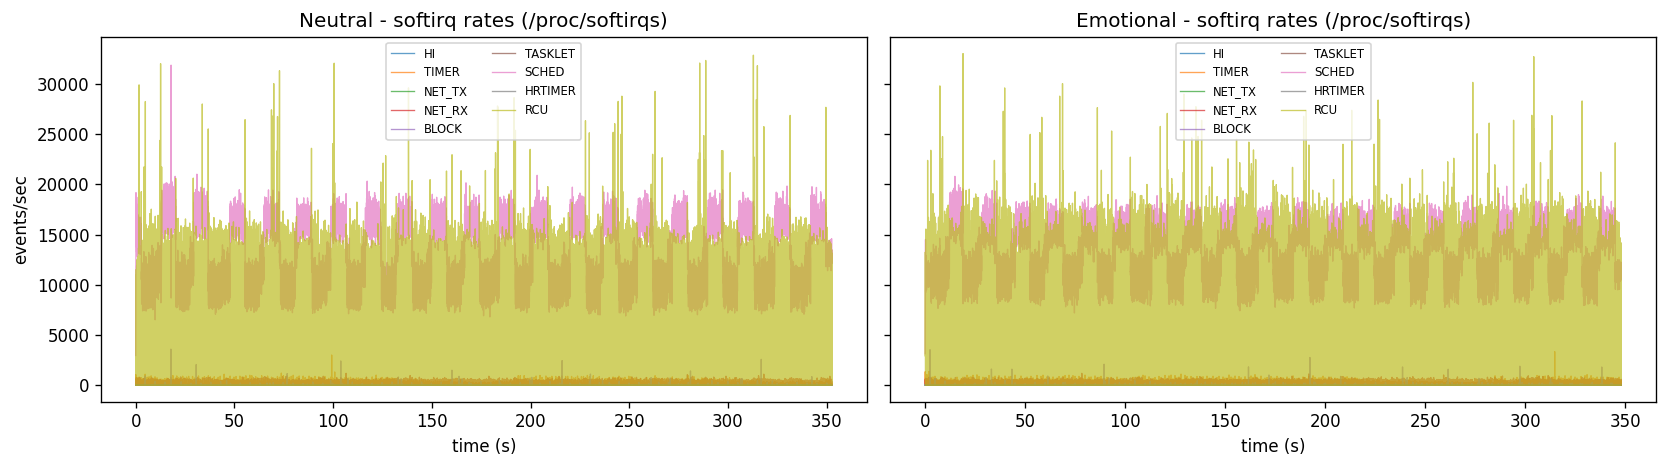

In [60]:
softirq_names = ['HI', 'TIMER', 'NET_TX', 'NET_RX', 'BLOCK', 'TASKLET', 'SCHED', 'HRTIMER', 'RCU']
available_sirqs = [s for s in softirq_names if s in n_hat.columns]

if available_sirqs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    for ax, label, df, color in [
        (axes[0], 'Neutral',   n_hat, 'steelblue'),
        (axes[1], 'Emotional', e_hat, 'firebrick'),
    ]:
        for sirq in available_sirqs:
            rate = df[sirq].diff() / df['t_s'].diff()
            ax.plot(df['t_s'], rate, lw=0.8, alpha=0.7, label=sirq)
        ax.set_title(f'{label} - softirq rates (/proc/softirqs)')
        ax.set_xlabel('time (s)')
        ax.legend(fontsize=7, ncol=2)
    axes[0].set_ylabel('events/sec')
    plt.tight_layout()
    plt.show()
else:
    print('No softirq columns found')

In [61]:
# Quick data quality check
print('── Data Quality ──')
for evt in common_events:
    n_sum, e_sum = n_perf[evt].sum(), e_perf[evt].sum()
    if n_sum == 0 and e_sum == 0:
        print(f'  ⚠ {evt}: zero in both runs')
    elif n_sum == 0 or e_sum == 0:
        print(f'  ⚠ {evt}: zero in {"neutral" if n_sum == 0 else "emotional"} only')

dup_cols = n_hat.columns[n_hat.columns.duplicated()].tolist()
if dup_cols:
    print(f'  ⚠ Duplicate columns in hat_interrupts: {set(dup_cols)}')

── Data Quality ──
  ⚠ mce:mce_record: zero in both runs
  ⚠ stalled-cycles-backend: zero in both runs
  ⚠ stalled-cycles-frontend: zero in both runs


## 8 — Feature Engineering

Each prompt's request window (start → end in the perf time-series) becomes one
observation. We extract features in 5 categories from the 1 ms HAT event counts:

| Category | Features | What it captures |
|----------|----------|-----------------|
| **Frequency** | event rate, relative share | How often each HAT event fires per second |
| **Temporal** | inter-arrival entropy, Fano factor | Regularity vs burstiness of event timing |
| **Burst** | burst count/rate/size/duration/clustering | Concentrated activity patterns |
| **Coupling** | cross-correlation, mutual information | Interaction between HAT event pairs |
| **Complexity** | Lempel-Ziv, permutation entropy | Randomness vs structure in the signal |

**HAT event groups:**
- **Layer 1 tracepoints** (7): irq handlers, softirq, TLB flush, thermal throttle
- **Layer 2 PMU** (10): cache/LLC/branch/TLB misses, instructions, cycles, pipeline stalls
- **Layer 2 power/thermal** (3): RAPL energy (pkg+ram), thermal margin
- **Supporting confounders** (4): context-switches, cpu-migrations, page-faults, cpu-clock

With ~24 events × 12 feature types + coupling pairs → ~300+ features per prompt
(after dropping zero-variance columns).

In [62]:
from scipy import stats as sp_stats
from collections import defaultdict

def extract_request_series(perf_df, wins, events=None):
    """Return list of dicts {event: np.array} for each request window."""
    if events is None:
        events = [c for c in perf_df.columns if c != 't_s']
    segments = []
    for start, end in wins:
        mask = (perf_df['t_s'] >= start) & (perf_df['t_s'] <= end)
        seg = {evt: perf_df.loc[mask, evt].values.astype(float) for evt in events}
        seg['_t_s'] = perf_df.loc[mask, 't_s'].values
        seg['_duration_s'] = end - start
        segments.append(seg)
    return segments

n_segs = extract_request_series(n_perf, n_wins, common_events)
e_segs = extract_request_series(e_perf, e_wins, common_events)
print(f'Segments: {len(n_segs)} neutral, {len(e_segs)} emotional')

Segments: 20 neutral, 20 emotional


### 8.1 — Frequency features

**Event rate** = total count ÷ window duration (events/s).
**Relative share** = fraction of all events. These capture interrupt *intensity*.

In [63]:
# ── 6.1  Frequency Features ──
def compute_frequency_features(segments, events):
    """Return DataFrame: rows = segments, cols = event_rate, event_share."""
    rows = []
    for seg in segments:
        dur = seg['_duration_s']
        rates = {}
        for evt in events:
            rates[evt] = seg[evt].sum() / dur if dur > 0 else 0.0
        total_rate = sum(rates.values())
        row = {}
        for evt in events:
            row[f'{evt}__rate'] = rates[evt]
            row[f'{evt}__share'] = rates[evt] / total_rate if total_rate > 0 else 0.0
        rows.append(row)
    return pd.DataFrame(rows)

n_freq = compute_frequency_features(n_segs, common_events)
e_freq = compute_frequency_features(e_segs, common_events)

# ── Summary table ──
rate_cols = [c for c in n_freq.columns if c.endswith('__rate')]
summary = []
for col in rate_cols:
    evt = col.replace('__rate', '')
    summary.append({
        'event': evt,
        'neutral_rate_mean': n_freq[col].mean(),
        'neutral_rate_std': n_freq[col].std(),
        'emotional_rate_mean': e_freq[col].mean(),
        'emotional_rate_std': e_freq[col].std(),
        'ratio_E/N': e_freq[col].mean() / n_freq[col].mean() if n_freq[col].mean() > 0 else np.nan,
    })
freq_summary = pd.DataFrame(summary).sort_values('neutral_rate_mean', ascending=False)
print('Event rates (events/s) per request window:\n')
print(freq_summary.to_string(index=False, float_format='{:.2f}'.format))

Event rates (events/s) per request window:

                  event  neutral_rate_mean  neutral_rate_std  emotional_rate_mean  emotional_rate_std  ratio_E/N
           instructions     57201616726.07     1584518892.38       56911947595.82       1307627648.04       0.99
                 cycles     37119539364.48      768479450.65       37223759438.63        673922500.64       1.00
    branch-instructions      1869068969.12       17350496.73        1875975488.03         20026863.09       1.00
       cache-references       467095621.25       10728022.50         464883369.72          9169643.82       1.00
    core_power.throttle       423541154.61       76548504.05         419092209.68         87620782.71       0.99
           cache-misses       248716147.97        8755651.63         250269537.82          7876430.23       1.01
          branch-misses        49719098.77        1089678.38          49411592.56           411959.18       0.99
        LLC-load-misses        40144285.03         9

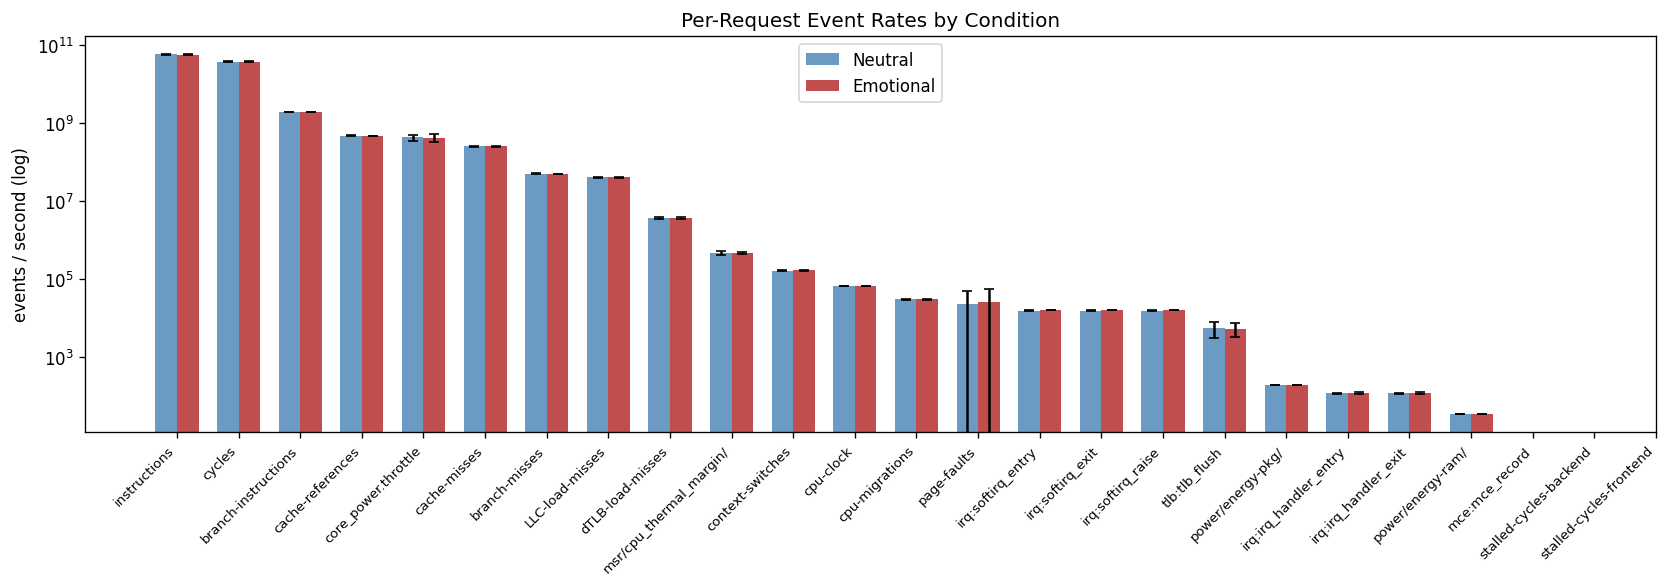

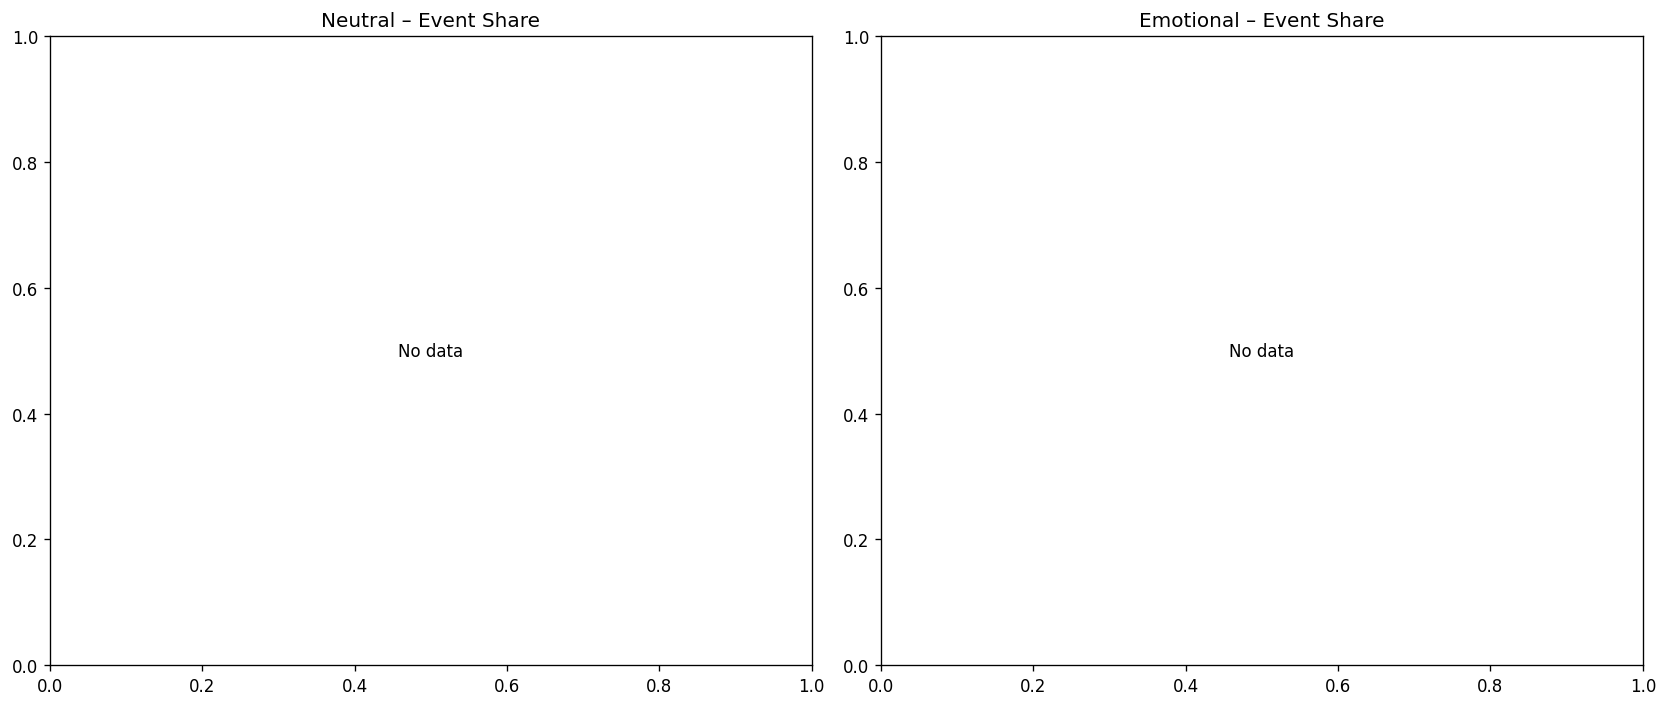

In [64]:
# ── 6.1 plot: Event rates grouped bar ──
rate_events = freq_summary['event'].values
x = np.arange(len(rate_events))
w = 0.35

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x - w/2, freq_summary['neutral_rate_mean'],  w, yerr=freq_summary['neutral_rate_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=3)
ax.bar(x + w/2, freq_summary['emotional_rate_mean'], w, yerr=freq_summary['emotional_rate_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=3)
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(rate_events, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('events / second (log)')
ax.set_title('Per-Request Event Rates by Condition')
ax.legend()
plt.tight_layout()
plt.show()

# ── Relative share pie charts ──
share_cols = [c for c in n_freq.columns if c.endswith('__share')]
n_shares = n_freq[share_cols].mean()
e_shares = e_freq[share_cols].mean()
labels = [c.replace('__share', '') for c in share_cols]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, shares, title, cmap in [
    (axes[0], n_shares.values, 'Neutral – Event Share', 'Blues'),
    (axes[1], e_shares.values, 'Emotional – Event Share', 'Reds'),
]:
    # Collapse tiny slices into "other"; skip if total is zero
    total = shares.sum()
    if total == 0 or np.isnan(total):
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        continue
    thresh = 0.02
    big = shares >= thresh
    plot_shares = list(shares[big]) + [shares[~big].sum()]
    plot_labels = [labels[i] for i in range(len(labels)) if big[i]] + ['other']
    # Drop any zero-value slices to avoid div-by-zero in matplotlib pie
    nonzero = [(s, l) for s, l in zip(plot_shares, plot_labels) if s > 0]
    if not nonzero:
        ax.text(0.5, 0.5, 'All zero', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        continue
    plot_shares, plot_labels = zip(*nonzero)
    ax.pie(plot_shares, labels=plot_labels, autopct='%1.1f%%', startangle=90,
           textprops={'fontsize': 7},
           colors=plt.colormaps[cmap](np.linspace(0.3, 0.9, len(plot_shares))))
    ax.set_title(title)
plt.tight_layout()
plt.show()

### 8.2 — Temporal structure

**Inter-arrival entropy** (bits): how irregular the spacing between events is.
Higher = more random timing.
**Fano factor** ($F = \sigma^2 / \mu$ in 100 ms bins): $F = 1$ is Poisson,
$F > 1$ is bursty, $F < 1$ is regular.

In [65]:
# ── 6.2  Temporal Structure ──

def shannon_entropy_bits(arr):
    """Shannon entropy of a discrete distribution (in bits)."""
    arr = arr[arr > 0]
    if len(arr) == 0:
        return 0.0
    p = arr / arr.sum()
    return -np.sum(p * np.log2(p))


def inter_arrival_entropy(series):
    """Entropy of inter-arrival time distribution for a 1ms count series."""
    arrivals = np.where(series > 0)[0]  # indices where count > 0
    if len(arrivals) < 2:
        return 0.0
    iat = np.diff(arrivals)  # inter-arrival times in ms
    counts = np.bincount(iat)
    return shannon_entropy_bits(counts.astype(float))


def fano_factor(series, bin_size=100):
    """Fano factor from non-overlapping bins of `bin_size` ms."""
    n_bins = len(series) // bin_size
    if n_bins < 2:
        return np.nan
    trimmed = series[:n_bins * bin_size]
    binned = trimmed.reshape(n_bins, bin_size).sum(axis=1)
    mu = binned.mean()
    if mu == 0:
        return np.nan
    return binned.var(ddof=1) / mu


def compute_temporal_features(segments, events):
    rows = []
    for seg in segments:
        row = {}
        for evt in events:
            s = seg[evt]
            row[f'{evt}__iat_entropy'] = inter_arrival_entropy(s)
            row[f'{evt}__fano'] = fano_factor(s, bin_size=100)
        rows.append(row)
    return pd.DataFrame(rows)

n_temp = compute_temporal_features(n_segs, common_events)
e_temp = compute_temporal_features(e_segs, common_events)

# ── summary ──
temp_summary = []
for evt in common_events:
    ec, fc = f'{evt}__iat_entropy', f'{evt}__fano'
    temp_summary.append({
        'event': evt,
        'n_entropy': n_temp[ec].mean(), 'n_entropy_std': n_temp[ec].std(),
        'e_entropy': e_temp[ec].mean(), 'e_entropy_std': e_temp[ec].std(),
        'n_fano':    n_temp[fc].mean(), 'n_fano_std':    n_temp[fc].std(),
        'e_fano':    e_temp[fc].mean(), 'e_fano_std':    e_temp[fc].std(),
    })
temp_df = pd.DataFrame(temp_summary)
print(f'Temporal Structure features (mean ± std across {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(temp_df.to_string(index=False, float_format='{:.3f}'.format))

Temporal Structure features (mean ± std across 20 neutral / 20 emotional prompts):

                  event  n_entropy  n_entropy_std  e_entropy  e_entropy_std          n_fano    n_fano_std          e_fano    e_fano_std
        LLC-load-misses      0.000          0.000      0.000          0.000    16006052.556   1403491.222    15971314.270   1102318.123
    branch-instructions      0.000          0.000      0.000          0.000    45317368.349  11212295.186    50196612.805  14432211.616
          branch-misses      0.000          0.000      0.000          0.000      946238.359    716667.568      697128.157    233710.211
           cache-misses      0.000          0.000      0.000          0.000    86693238.731   3817103.730    86964040.142   4510041.492
       cache-references      0.000          0.000      0.000          0.000    12599145.729   3229012.631    14029244.078   4024636.683
       context-switches      0.000          0.000      0.000          0.000       72973.997      318

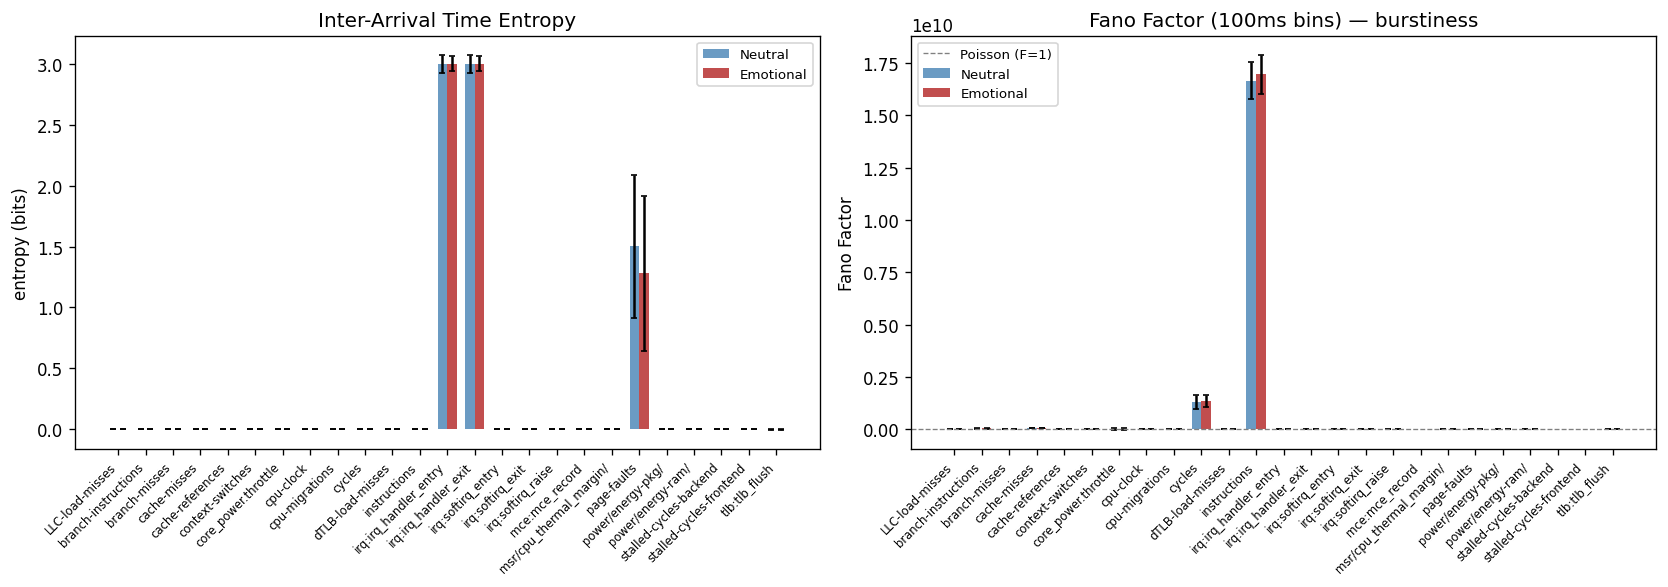

In [66]:
# ── 6.2 plot: Entropy & Fano Factor ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy
x = np.arange(len(common_events))
w = 0.35
ax = axes[0]
ax.bar(x - w/2, temp_df['n_entropy'], w, yerr=temp_df['n_entropy_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, temp_df['e_entropy'], w, yerr=temp_df['e_entropy_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('entropy (bits)')
ax.set_title('Inter-Arrival Time Entropy')
ax.legend(fontsize=8)

# Fano Factor
ax = axes[1]
ax.bar(x - w/2, temp_df['n_fano'], w, yerr=temp_df['n_fano_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, temp_df['e_fano'], w, yerr=temp_df['e_fano_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.axhline(1.0, ls='--', color='gray', lw=0.8, label='Poisson (F=1)')
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('Fano Factor')
ax.set_title('Fano Factor (100ms bins) — burstiness')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 8.3 — Burst statistics

A **burst** = contiguous run of 1 ms bins where count > mean + 1σ.
We extract burst count, size, duration, rate, and **clustering coefficient**
(fraction of all events occurring inside bursts). Higher clustering = more
concentrated activity.

In [67]:
# ── 6.3  Burst Statistics ──

def burst_stats(series):
    """Detect bursts (contiguous runs > mean+1σ) and return statistics."""
    mu, sigma = series.mean(), series.std()
    if sigma == 0 or mu == 0:
        return dict(burst_count=0, mean_burst_size=0.0,
                    mean_burst_dur_ms=0.0, burst_clustering=0.0)
    thresh = mu + sigma
    above = (series > thresh).astype(int)
    # Find burst boundaries via diff
    diff = np.diff(np.concatenate(([0], above, [0])))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    if len(starts) == 0:
        return dict(burst_count=0, mean_burst_size=0.0,
                    mean_burst_dur_ms=0.0, burst_clustering=0.0)
    burst_sizes = [series[s:e].sum() for s, e in zip(starts, ends)]
    burst_durs  = ends - starts  # in ms
    total_in_bursts = sum(burst_sizes)
    total_events = series.sum()
    return dict(
        burst_count=len(starts),
        mean_burst_size=np.mean(burst_sizes),
        mean_burst_dur_ms=np.mean(burst_durs),
        burst_clustering=total_in_bursts / total_events if total_events > 0 else 0.0,
    )


def compute_burst_features(segments, events):
    rows = []
    for seg in segments:
        dur = seg['_duration_s']
        row = {}
        for evt in events:
            bs = burst_stats(seg[evt])
            for k, v in bs.items():
                row[f'{evt}__{k}'] = v
            # Duration-normalised burst rate (bursts per second)
            row[f'{evt}__burst_rate'] = bs['burst_count'] / dur if dur > 0 else 0.0
        row['_window_duration_s'] = dur
        rows.append(row)
    return pd.DataFrame(rows)

n_burst = compute_burst_features(n_segs, common_events)
e_burst = compute_burst_features(e_segs, common_events)

# ── summary ──
burst_summary = []
for evt in common_events:
    d = {'event': evt}
    for metric in ['burst_count', 'burst_rate', 'mean_burst_size', 'mean_burst_dur_ms', 'burst_clustering']:
        col = f'{evt}__{metric}'
        d[f'n_{metric}'] = n_burst[col].mean()
        d[f'e_{metric}'] = e_burst[col].mean()
    burst_summary.append(d)
burst_df = pd.DataFrame(burst_summary)
print(f'Burst Statistics (mean across {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(burst_df.to_string(index=False, float_format='{:.2f}'.format))

Burst Statistics (mean across 20 neutral / 20 emotional prompts):

                  event  n_burst_count  e_burst_count  n_burst_rate  e_burst_rate  n_mean_burst_size  e_mean_burst_size  n_mean_burst_dur_ms  e_mean_burst_dur_ms  n_burst_clustering  e_burst_clustering
        LLC-load-misses         323.60         319.40         18.68         18.68          908614.57          888721.40                 1.39                 1.36                0.42                0.41
    branch-instructions          97.40          95.90          5.63          5.61        77590987.18        76985194.45                 1.74                 1.73                0.23                0.23
          branch-misses         123.65         124.00          7.13          7.24         1734069.01         1669958.25                 1.48                 1.50                0.25                0.24
           cache-misses         337.10         341.30         19.47         19.96         5019877.23         4811761.66      

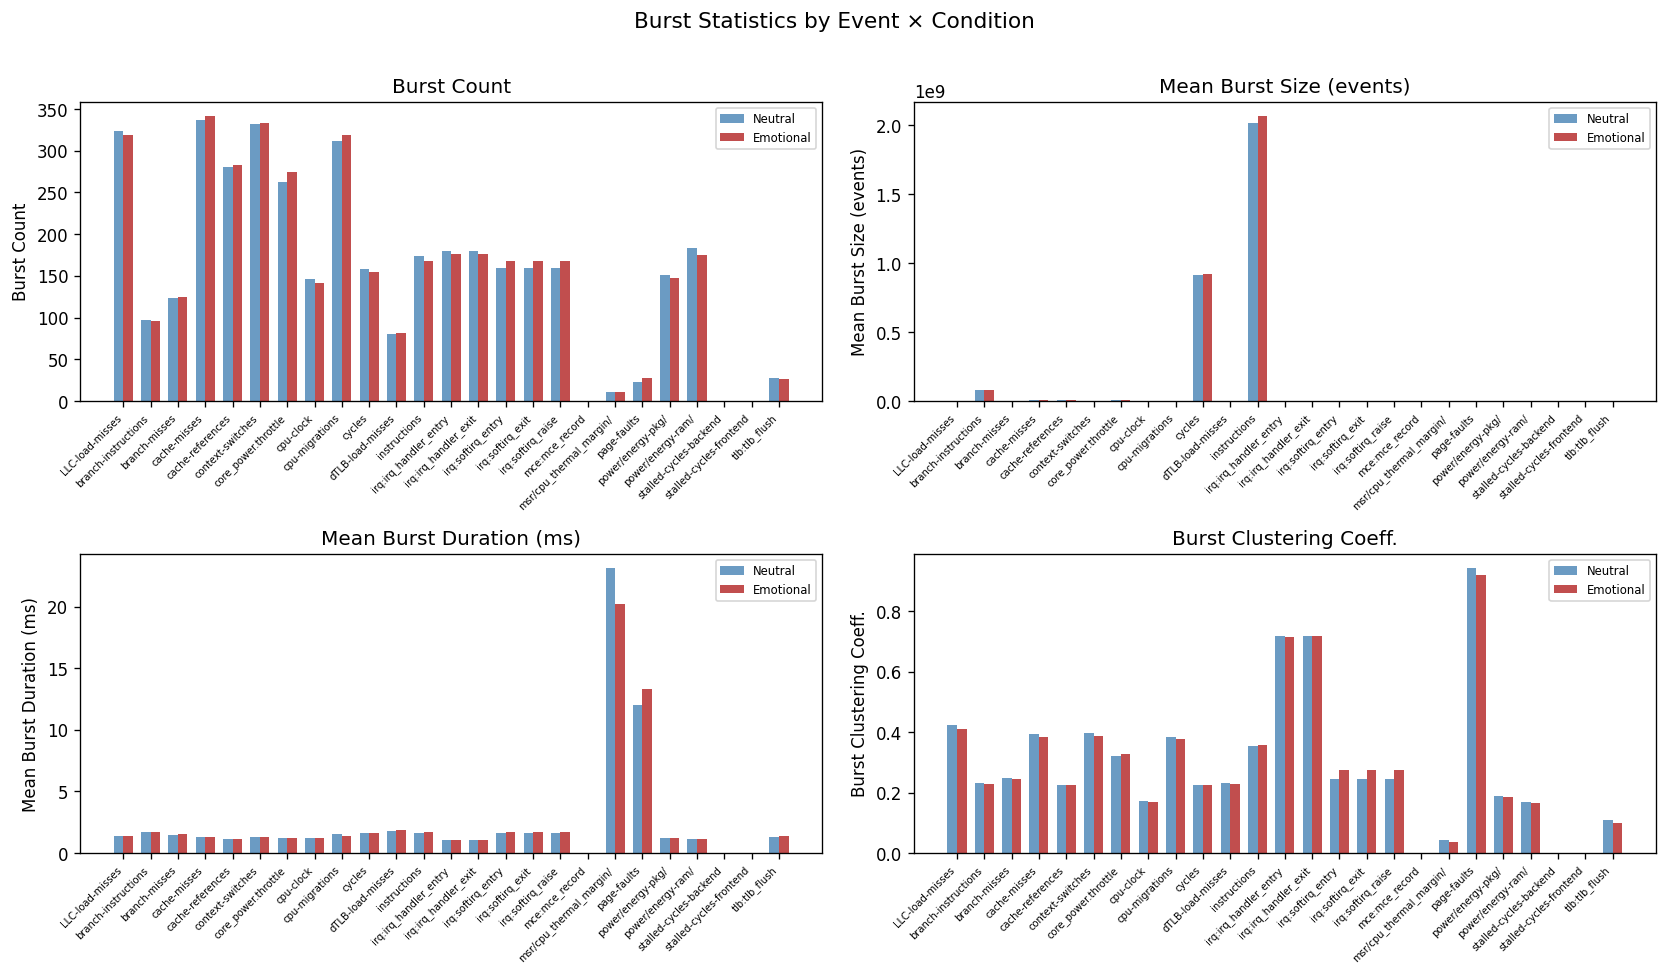

In [68]:
# ── 6.3 plot: Burst Statistics ──
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
x = np.arange(len(common_events))
w = 0.35

metrics = [
    ('burst_count',      'Burst Count',               axes[0, 0]),
    ('mean_burst_size',  'Mean Burst Size (events)',   axes[0, 1]),
    ('mean_burst_dur_ms','Mean Burst Duration (ms)',   axes[1, 0]),
    ('burst_clustering', 'Burst Clustering Coeff.',    axes[1, 1]),
]

for metric, ylabel, ax in metrics:
    n_vals = burst_df[f'n_{metric}'].values
    e_vals = burst_df[f'e_{metric}'].values
    ax.bar(x - w/2, n_vals, w, label='Neutral',   color='steelblue', alpha=0.8)
    ax.bar(x + w/2, e_vals, w, label='Emotional',  color='firebrick', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=6)
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.legend(fontsize=7)

plt.suptitle('Burst Statistics by Event × Condition', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 8.4 — Cross-modal coupling

Measures interaction between HAT event pairs. Pairs are organised as:
- **HAT L1 ↔ L1** (interrupt interactions): IRQ ↔ softirq, page-fault ↔ TLB flush
- **HAT L2 ↔ L2** (PMU microarchitecture): cache misses ↔ references, branch miss ↔ instructions, IPC
- **Cross-layer L1 ↔ L2**: IRQ pressure ↔ pipeline stalls, TLB flush ↔ dTLB misses

**Max cross-correlation** (±50 ms lag) captures linear dependence;
**mutual information** captures non-linear dependence.

In [69]:
# ── 6.4  Cross-Modal Coupling ──

EVENT_PAIRS = [
    # HAT Layer 1: interrupt interactions
    ('irq:irq_handler_entry', 'irq:softirq_entry'),
    ('irq:softirq_raise',     'irq:softirq_entry'),
    ('irq:irq_handler_entry', 'irq:irq_handler_exit'),
    ('irq:softirq_entry',     'irq:softirq_exit'),
    ('page-faults',            'tlb:tlb_flush'),
    # HAT Layer 2: PMU microarchitecture interactions
    ('cache-misses',          'cache-references'),       # cache miss rate coupling
    ('branch-misses',         'branch-instructions'),    # branch misprediction coupling
    ('stalled-cycles-backend','cache-misses'),            # memory stalls driven by cache misses
    ('stalled-cycles-frontend','branch-misses'),          # frontend stalls driven by mispredictions
    ('LLC-load-misses',       'dTLB-load-misses'),       # LLC vs TLB pressure
    ('instructions',          'cycles'),                 # IPC coupling
    # Cross-layer: L1 anomaly ↔ L2 performance
    ('irq:irq_handler_entry', 'stalled-cycles-backend'), # IRQ pressure → pipeline stall
    ('tlb:tlb_flush',         'dTLB-load-misses'),       # TLB shootdown → TLB miss rate
    # Supporting confounder interactions
    ('context-switches',      'cpu-migrations'),
]

# Keep only pairs where both events exist in data
EVENT_PAIRS = [(a, b) for a, b in EVENT_PAIRS
               if a in common_events and b in common_events]
print(f'Event pairs to analyze: {len(EVENT_PAIRS)}')


def max_xcorr(x, y, max_lag=50):
    """Max absolute cross-correlation in ±max_lag ms."""
    if len(x) == 0 or len(y) == 0:
        return 0.0, 0
    if x.std() == 0 or y.std() == 0:
        return 0.0, 0
    x = (x - x.mean()) / (x.std() + 1e-12)
    y = (y - y.mean()) / (y.std() + 1e-12)
    n = len(x)
    best_r, best_lag = 0.0, 0
    for lag in range(-max_lag, max_lag + 1):
        if lag >= 0:
            r = np.dot(x[:n-lag], y[lag:]) / (n - abs(lag))
        else:
            r = np.dot(x[-lag:], y[:n+lag]) / (n - abs(lag))
        if abs(r) > abs(best_r):
            best_r, best_lag = r, lag
    return best_r, best_lag


def mutual_information(x, y, bins=20):
    """MI estimated from 2D histogram (bits)."""
    # Guard against constant or all-NaN series
    if len(x) == 0 or len(y) == 0:
        return 0.0
    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        return 0.0
    if np.nanstd(x) == 0 or np.nanstd(y) == 0:
        return 0.0
    # Drop NaN pairs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if len(x) < 2:
        return 0.0
    c_xy = np.histogram2d(x, y, bins=bins)[0]
    c_xy = c_xy / c_xy.sum()
    c_x = c_xy.sum(axis=1)
    c_y = c_xy.sum(axis=0)
    # H(X) + H(Y) - H(X,Y)
    hx  = shannon_entropy_bits(c_x)
    hy  = shannon_entropy_bits(c_y)
    hxy = shannon_entropy_bits(c_xy.ravel())
    return hx + hy - hxy


def compute_coupling_features(segments, pairs):
    rows = []
    for seg in segments:
        row = {}
        for a, b in pairs:
            sa, sb = seg[a], seg[b]
            r, lag = max_xcorr(sa, sb)
            mi = mutual_information(sa, sb)
            pair_label = f'{a}__x__{b}'
            row[f'{pair_label}__xcorr'] = r
            row[f'{pair_label}__xcorr_lag'] = lag
            row[f'{pair_label}__mi'] = mi
        rows.append(row)
    return pd.DataFrame(rows)

n_coup = compute_coupling_features(n_segs, EVENT_PAIRS)
e_coup = compute_coupling_features(e_segs, EVENT_PAIRS)

# ── summary ──
coup_summary = []
for a, b in EVENT_PAIRS:
    pl = f'{a}__x__{b}'
    coup_summary.append({
        'pair': f'{a.split(":")[-1]}↔{b.split(":")[-1]}',
        'n_xcorr': n_coup[f'{pl}__xcorr'].mean(),
        'e_xcorr': e_coup[f'{pl}__xcorr'].mean(),
        'n_lag':   n_coup[f'{pl}__xcorr_lag'].mean(),
        'e_lag':   e_coup[f'{pl}__xcorr_lag'].mean(),
        'n_mi':    n_coup[f'{pl}__mi'].mean(),
        'e_mi':    e_coup[f'{pl}__mi'].mean(),
    })

coup_df = pd.DataFrame(coup_summary)
print(f'Cross-Modal Coupling (mean over {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(coup_df.to_string(index=False, float_format='{:.4f}'.format))

Event pairs to analyze: 14
Cross-Modal Coupling (mean over 20 neutral / 20 emotional prompts):

                                    pair  n_xcorr  e_xcorr   n_lag   e_lag   n_mi   e_mi
         irq_handler_entry↔softirq_entry   0.1345   0.1466  0.0000  0.0000 0.0692 0.0640
             softirq_raise↔softirq_entry   1.0000   1.0000  0.0000  0.0000 2.6765 2.5326
      irq_handler_entry↔irq_handler_exit   1.0000   1.0000  0.0000  0.0000 1.2587 1.1785
              softirq_entry↔softirq_exit   1.0000   1.0000  0.0000  0.0000 2.6928 2.5528
                   page-faults↔tlb_flush  -0.3269  -0.3064 -1.4000  1.3000 0.1474 0.1457
           cache-misses↔cache-references   0.5965   0.6098  0.0000  0.0000 1.0253 1.1664
       branch-misses↔branch-instructions   0.5810   0.5786  0.0000  0.0000 0.7503 0.7607
     stalled-cycles-backend↔cache-misses   0.0000   0.0000  0.0000  0.0000 0.0000 0.0000
   stalled-cycles-frontend↔branch-misses   0.0000   0.0000  0.0000  0.0000 0.0000 0.0000
        LLC-lo

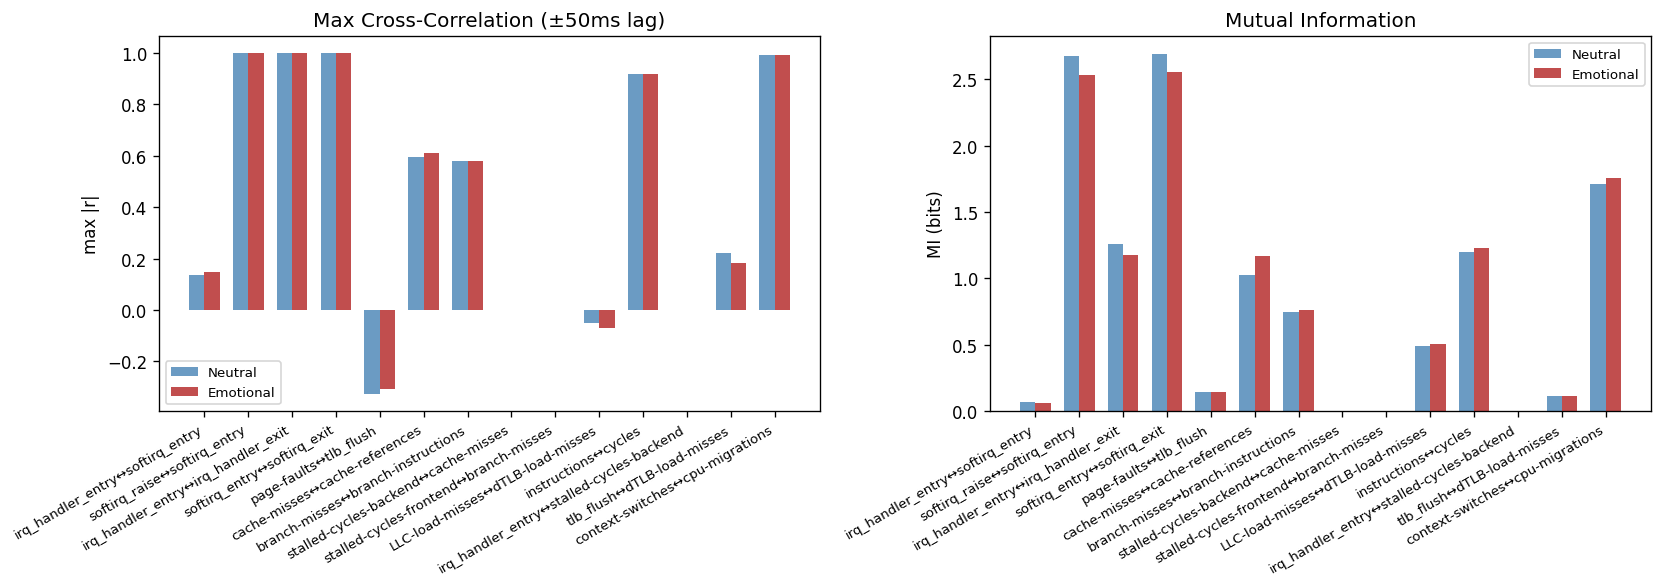

In [70]:
# ── 6.4 plot: Cross-correlation & MI ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(coup_df))
w = 0.35
pair_labels = coup_df['pair'].values

ax = axes[0]
ax.bar(x - w/2, coup_df['n_xcorr'], w, label='Neutral',  color='steelblue', alpha=0.8)
ax.bar(x + w/2, coup_df['e_xcorr'], w, label='Emotional', color='firebrick', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=30, ha='right', fontsize=8)
ax.set_ylabel('max |r|')
ax.set_title('Max Cross-Correlation (±50ms lag)')
ax.legend(fontsize=8)

ax = axes[1]
ax.bar(x - w/2, coup_df['n_mi'], w, label='Neutral',  color='steelblue', alpha=0.8)
ax.bar(x + w/2, coup_df['e_mi'], w, label='Emotional', color='firebrick', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=30, ha='right', fontsize=8)
ax.set_ylabel('MI (bits)')
ax.set_title('Mutual Information')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 8.5 — Complexity

**Lempel-Ziv complexity** (normalised): binarise the series (above/below median),
then measure compressibility. Higher = more random.
**Permutation entropy** (order 3, normalised 0–1): measures ordinal pattern diversity.
1 = maximally complex, 0 = perfectly periodic.

In [71]:
# ── 6.5  Complexity ──

def lempel_ziv_complexity(binary_seq):
    """LZ76 complexity of a binary string, normalised by n/log2(n)."""
    s = ''.join(str(int(b)) for b in binary_seq)
    n = len(s)
    if n <= 1:
        return 0.0
    i, k, l = 0, 1, 1
    c = 1
    while k + l <= n:
        if s[i + l - 1] == s[k + l - 1]:
            l += 1
        else:
            i += 1
            if i == k:  # new word
                c += 1
                k += l
                i = 0
                l = 1
            else:
                l = 1
    c += 1
    # normalise: theoretical max ≈ n / log2(n)
    return c / (n / np.log2(n)) if n > 1 else 0.0


def permutation_entropy(series, order=3):
    """Normalised permutation entropy (0–1) of order m."""
    n = len(series)
    if n < order:
        return 0.0
    from itertools import permutations as iterperms
    import math
    # Count ordinal patterns
    pattern_counts = defaultdict(int)
    for i in range(n - order + 1):
        window = series[i:i+order]
        # rank pattern
        pattern = tuple(np.argsort(window))
        pattern_counts[pattern] += 1
    total = sum(pattern_counts.values())
    probs = np.array(list(pattern_counts.values())) / total
    h = -np.sum(probs * np.log2(probs + 1e-15))
    h_max = np.log2(math.factorial(order))
    return h / h_max if h_max > 0 else 0.0


def compute_complexity_features(segments, events):
    rows = []
    for seg in segments:
        row = {}
        for evt in events:
            s = seg[evt]
            # Binarise: above median → 1
            binary = (s > np.median(s)).astype(int)
            row[f'{evt}__lz_complexity'] = lempel_ziv_complexity(binary)
            row[f'{evt}__perm_entropy']  = permutation_entropy(s, order=3)
        rows.append(row)
    return pd.DataFrame(rows)

n_complex = compute_complexity_features(n_segs, common_events)
e_complex = compute_complexity_features(e_segs, common_events)

# ── summary ──
complex_summary = []
for evt in common_events:
    lz_col = f'{evt}__lz_complexity'
    pe_col = f'{evt}__perm_entropy'
    complex_summary.append({
        'event': evt,
        'n_lz': n_complex[lz_col].mean(), 'n_lz_std': n_complex[lz_col].std(),
        'e_lz': e_complex[lz_col].mean(), 'e_lz_std': e_complex[lz_col].std(),
        'n_pe': n_complex[pe_col].mean(), 'n_pe_std': n_complex[pe_col].std(),
        'e_pe': e_complex[pe_col].mean(), 'e_pe_std': e_complex[pe_col].std(),
    })
complex_df = pd.DataFrame(complex_summary)
print(f'Complexity features (mean ± std across {len(n_segs)} neutral / {len(e_segs)} emotional prompts):\n')
print(complex_df.to_string(index=False, float_format='{:.4f}'.format))

Complexity features (mean ± std across 20 neutral / 20 emotional prompts):

                  event   n_lz  n_lz_std   e_lz  e_lz_std    n_pe  n_pe_std    e_pe  e_pe_std
        LLC-load-misses 0.5845    0.2436 0.4981    0.1905  0.9979    0.0012  0.9977    0.0014
    branch-instructions 5.7074    0.1381 5.7369    0.0853  0.9938    0.0028  0.9953    0.0024
          branch-misses 5.8511    0.1412 5.8297    0.1277  0.9989    0.0017  0.9989    0.0008
           cache-misses 0.5076    0.1578 0.4820    0.2438  0.9962    0.0017  0.9959    0.0016
       cache-references 3.9433    0.2940 3.8567    0.2531  0.9981    0.0016  0.9974    0.0013
       context-switches 0.3243    0.2099 0.2800    0.2162  0.9982    0.0009  0.9985    0.0008
    core_power.throttle 4.3909    0.6200 4.4342    0.7079  0.9992    0.0005  0.9993    0.0005
              cpu-clock 5.5803    0.1598 5.5382    0.1442  0.9936    0.0044  0.9946    0.0026
         cpu-migrations 0.2958    0.1847 0.2702    0.1979  0.9968    0.0022  0

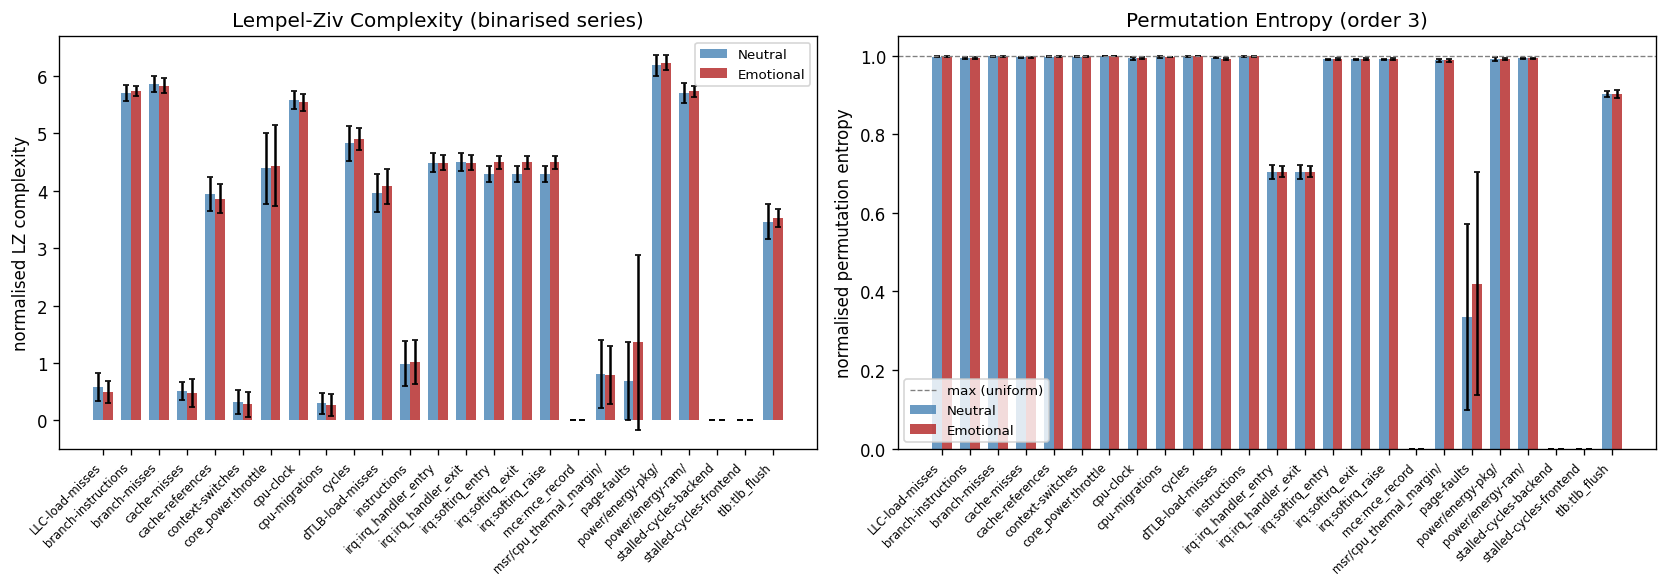

In [72]:
# ── 6.5 plot: Complexity ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(common_events))
w = 0.35

ax = axes[0]
ax.bar(x - w/2, complex_df['n_lz'], w, yerr=complex_df['n_lz_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, complex_df['e_lz'], w, yerr=complex_df['e_lz_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('normalised LZ complexity')
ax.set_title('Lempel-Ziv Complexity (binarised series)')
ax.legend(fontsize=8)

ax = axes[1]
ax.bar(x - w/2, complex_df['n_pe'], w, yerr=complex_df['n_pe_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, complex_df['e_pe'], w, yerr=complex_df['e_pe_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.axhline(1.0, ls='--', color='gray', lw=0.8, label='max (uniform)')
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('normalised permutation entropy')
ax.set_title('Permutation Entropy (order 3)')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 8.6 — Combined feature matrix & univariate screening

Merge all features into one matrix (40 rows × ~160 columns). Then run
**Mann-Whitney U** tests per feature as a quick screen — these are univariate
(one feature at a time) and uncorrected, so they're exploratory, not conclusive.

In [73]:
# ── 6.6  Combined Feature Matrix ──

def build_feature_matrix(freq, temp, burst, coupling, complexity, condition):
    """Merge all feature DataFrames into one row-per-prompt matrix."""
    combined = pd.concat([freq, temp, burst, coupling, complexity], axis=1)
    combined.insert(0, 'condition', condition)
    combined.insert(1, 'prompt_id', range(len(combined)))
    # Keep window duration for reference (from burst df)
    if '_window_duration_s' in combined.columns:
        combined.insert(2, 'window_duration_s', combined.pop('_window_duration_s'))
    return combined

n_all = build_feature_matrix(n_freq, n_temp, n_burst, n_coup, n_complex, 'neutral')
e_all = build_feature_matrix(e_freq, e_temp, e_burst, e_coup, e_complex, 'emotional')
features = pd.concat([n_all, e_all], ignore_index=True)

print(f'Feature matrix: {features.shape[0]} rows × {features.shape[1]} columns')
print(f'  Neutral rows:   {(features.condition == "neutral").sum()}')
print(f'  Emotional rows: {(features.condition == "emotional").sum()}')
print(f'\nFeature categories:')
print(f'  Frequency:   {sum(c.endswith("__rate") or c.endswith("__share") for c in features.columns)}')
print(f'  Temporal:    {sum(c.endswith("__iat_entropy") or c.endswith("__fano") for c in features.columns)}')
print(f'  Burst:       {sum(any(c.endswith(s) for s in ["__burst_count","__burst_rate","__mean_burst_size","__mean_burst_dur_ms","__burst_clustering"]) for c in features.columns)}')
print(f'  Coupling:    {sum(c.endswith("__xcorr") or c.endswith("__mi") or c.endswith("__xcorr_lag") for c in features.columns)}')
print(f'  Complexity:  {sum(c.endswith("__lz_complexity") or c.endswith("__perm_entropy") for c in features.columns)}')

# ── Save ──
out_path = BASE_DIR / 'features.csv'
features.to_csv(out_path, index=False)
print(f'\nSaved → {out_path}')

Feature matrix: 40 rows × 320 columns
  Neutral rows:   20
  Emotional rows: 20

Feature categories:
  Frequency:   50
  Temporal:    50
  Burst:       125
  Coupling:    42
  Complexity:  50

Saved → /Users/rsalvi/Desktop/mccviahat/features.csv

Saved → /Users/rsalvi/Desktop/mccviahat/features.csv


In [74]:
# ── 6.6 Quick univariate screening: Mann-Whitney U ──
# (non-parametric, appropriate for small sample sizes)

exclude = {'condition', 'prompt_id', 'window_duration_s', '_window_duration_s'}
numeric_cols = [c for c in features.columns if c not in exclude]
n_vals = features[features.condition == 'neutral']
e_vals = features[features.condition == 'emotional']

n_per_group = len(n_vals)
e_per_group = len(e_vals)

# Print window durations for reference
print(f'Sample sizes: neutral={n_per_group}, emotional={e_per_group}')
print('Window durations (s):')
if 'window_duration_s' in features.columns:
    for cond in ['neutral', 'emotional']:
        durs = features.loc[features.condition == cond, 'window_duration_s']
        print(f'  {cond}: mean={durs.mean():.1f}, min={durs.min():.1f}, max={durs.max():.1f}')
print()

results = []
for col in numeric_cols:
    nv = n_vals[col].dropna().values
    ev = e_vals[col].dropna().values
    if len(nv) < 3 or len(ev) < 3:
        continue
    # check for zero-variance
    if nv.std() == 0 and ev.std() == 0:
        continue
    stat, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
    effect_r = 1 - (2 * stat) / (len(nv) * len(ev))  # rank-biserial r
    results.append({
        'feature': col,
        'U': stat,
        'p': p,
        'effect_r': effect_r,
        'n_mean': nv.mean(),
        'e_mean': ev.mean(),
        'direction': '↑E' if ev.mean() > nv.mean() else '↓E',
    })

mwu_df = pd.DataFrame(results).sort_values('p')
sig = mwu_df[mwu_df.p < 0.10]  # relaxed threshold given sample size
print(f'Features tested: {len(mwu_df)}, significant at p<0.10: {len(sig)}\n')
if len(sig) > 0:
    print(sig[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
        index=False, float_format='{:.4f}'.format))
else:
    print(f'No features reached p<0.10 (n={n_per_group}+{e_per_group} per condition).')
print('\n--- Top 15 features by p-value ---')
print(mwu_df.head(15)[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
    index=False, float_format='{:.4f}'.format))

Sample sizes: neutral=20, emotional=20
Window durations (s):
  neutral: mean=17.3, min=15.8, max=19.1
  emotional: mean=17.1, min=15.5, max=18.5

Features tested: 233, significant at p<0.10: 42

                                              feature        U      p  effect_r direction
                  irq:softirq_entry__burst_clustering   5.0000 0.0000    0.9750        ↑E
                  irq:softirq_raise__burst_clustering   7.0000 0.0000    0.9650        ↑E
                   irq:softirq_exit__burst_clustering   7.0000 0.0000    0.9650        ↑E
                              irq:softirq_raise__rate  12.0000 0.0000    0.9400        ↑E
                               irq:softirq_exit__rate  12.0000 0.0000    0.9400        ↑E
                              irq:softirq_entry__rate  12.0000 0.0000    0.9400        ↑E
                       dTLB-load-misses__perm_entropy 378.0000 0.0000   -0.8900        ↓E
                        irq:softirq_entry__burst_rate  33.0000 0.0000    0.8350      

## 9 — PERMANOVA with confounders

**PERMANOVA** tests whether the *multivariate centroid* of the HAT feature space
differs between conditions. Unlike Mann-Whitney (one feature at a time), this
considers all features simultaneously.

**Why confounders matter:** Some variables (prompt length, CPU frequency, request
duration) mechanically affect interrupt patterns regardless of emotional content.
If we don't control for them, a "significant" result may just mean the conditions
had different prompt lengths.

**Approach:**
1. Attach confounders from response metadata + /proc samples
2. Check confounder balance (are they already equal between conditions?)
3. Regress confounders out of every feature (OLS → keep residuals)
4. Run PERMANOVA on both raw and residualised features
5. If raw is significant but residualised is not → confounders explain the difference

| Confounder | Why it matters |
|---|---|
| `tokens_evaluated` | More input tokens → longer eval → different CPU/TLB profile |
| `prompt_id` | Later prompts see warmer CPU, thermal drift |
| `cpu_util_frac` | Background system load varies between windows |
| `cpu_freq_khz` | DVFS changes interrupt rates independently of content |

**Excluded:** `window_duration_s` (collinear with `tokens_evaluated`),
`predicted_ms`/`prompt_ms` (potential mediators, not confounders),
`tokens_predicted` (constant), `proc_cpu_frac` (tracks wrong PID).

In [75]:
# ── 7  PERMANOVA with Confounders ──
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist, squareform

# ── 7a. Build confounder matrix ──
# Confounders = variables that mechanically drive feature differences
# independent of emotional content.
#
#   tokens_evaluated  — prompt length → longer eval phase → different CPU/TLB profile
#   prompt_id         — temporal order → thermal drift over 8+ min run
#   cpu_util_frac     — per-request mean global CPU utilisation (1 - idle/total)
#   cpu_freq_khz      — per-request mean CPU frequency (DVFS confound)
#
# NOT included:
#   window_duration_s — nearly collinear with tokens_evaluated (with EOS fixed,
#                       all prompts produce 50 tokens); multicollinearity risk
#   proc_cpu_frac     — tracks Docker exec wrapper PID, not llama-server (broken)
#   tokens_predicted  — constant (n_predict=50, logit_bias), zero variance
#   predicted_ms      — potential mediator of the condition effect, not a confounder


def per_request_proc_stats(proc_df, wins):
    """Compute mean global CPU utilisation per request window."""
    rows = []
    for start, end in wins:
        mask = (proc_df['t_s'] >= start) & (proc_df['t_s'] <= end)
        chunk = proc_df.loc[mask]
        if len(chunk) < 2:
            rows.append({'cpu_util_frac': np.nan})
            continue
        d_total = chunk['cpu_total_jiffies'].iloc[-1] - chunk['cpu_total_jiffies'].iloc[0]
        d_idle = chunk['cpu_idle_jiffies'].iloc[-1] - chunk['cpu_idle_jiffies'].iloc[0]
        cpu_util = 1.0 - (d_idle / d_total) if d_total > 0 else np.nan
        rows.append({'cpu_util_frac': cpu_util})
    return pd.DataFrame(rows)


def per_request_freq(hat_df, wins):
    """Mean CPU frequency (kHz) per request window from hat_interrupts.csv."""
    freq_cols = [c for c in hat_df.columns if c.endswith('_freq_khz')]
    rows = []
    for start, end in wins:
        mask = (hat_df['t_s'] >= start) & (hat_df['t_s'] <= end)
        chunk = hat_df.loc[mask]
        if freq_cols and len(chunk) > 0:
            # Average across all cores and all samples in the window
            rows.append({'cpu_freq_khz': chunk[freq_cols].mean().mean()})
        else:
            rows.append({'cpu_freq_khz': np.nan})
    return pd.DataFrame(rows)


def get_confounders(resp_df, proc_df, hat_df, wins):
    """Build the full confounder DataFrame for one condition."""
    rows = []
    for idx, (_, r) in enumerate(resp_df.iterrows()):
        rows.append({
            'tokens_evaluated': r.get('tokens_evaluated', np.nan),
            'prompt_id': idx,   # temporal order within the run
        })
    conf = pd.DataFrame(rows)
    # Merge global CPU utilisation
    proc_stats = per_request_proc_stats(proc_df, wins)
    conf = pd.concat([conf, proc_stats], axis=1)
    # Merge CPU frequency from hat_interrupts.csv
    freq_stats = per_request_freq(hat_df, wins)
    conf = pd.concat([conf, freq_stats], axis=1)
    return conf


n_conf = get_confounders(n_resp, n_proc, n_hat, n_wins)
e_conf = get_confounders(e_resp, e_proc, e_hat, e_wins)

confounders = pd.concat([n_conf, e_conf], ignore_index=True)
confounder_cols = [c for c in confounders.columns if confounders[c].notna().sum() >= 5 and confounders[c].std() > 0]
print(f'Samples: {len(n_conf)} neutral + {len(e_conf)} emotional = {len(confounders)} total')
print(f'Confounders ({len(confounder_cols)}): {confounder_cols}')
print()
print(confounders[confounder_cols].describe().to_string(float_format='{:.2f}'.format))
print()

# Flag any confounders that differ significantly between conditions
print('── Confounder balance check (Mann-Whitney U) ──')
for col in confounder_cols:
    nv = n_conf[col].dropna().values
    ev = e_conf[col].dropna().values
    if len(nv) >= 3 and len(ev) >= 3:
        _, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
        flag = ' ← IMBALANCED' if p < 0.05 else ''
        print(f'  {col:25s}  n_mean={nv.mean():.2f}  e_mean={ev.mean():.2f}  p={p:.4f}{flag}')

# ── 7b. Get numeric features only ──
meta_cols = {'condition', 'prompt_id', 'window_duration_s', '_window_duration_s'}
feat_cols = [c for c in features.columns if c not in meta_cols]
X = features[feat_cols].copy()

# Drop columns that are all-zero or all-NaN
X = X.loc[:, X.std() > 0]
X = X.fillna(0)
print(f'\nFeature matrix for PERMANOVA: {X.shape[0]} samples × {X.shape[1]} features')

Samples: 20 neutral + 20 emotional = 40 total
Confounders (4): ['tokens_evaluated', 'prompt_id', 'cpu_util_frac', 'cpu_freq_khz']

       tokens_evaluated  prompt_id  cpu_util_frac  cpu_freq_khz
count             40.00      40.00          40.00         40.00
mean             633.50       9.50           0.21    2623671.34
std               51.92       5.84           0.00      17829.76
min              533.00       0.00           0.20    2592463.81
25%              597.50       4.75           0.21    2611631.18
50%              626.50       9.50           0.21    2617297.60
75%              673.50      14.25           0.21    2637804.72
max              758.00      19.00           0.22    2660733.27

── Confounder balance check (Mann-Whitney U) ──
  tokens_evaluated           n_mean=641.10  e_mean=625.90  p=0.4171
  prompt_id                  n_mean=9.50  e_mean=9.50  p=1.0000
  cpu_util_frac              n_mean=0.21  e_mean=0.21  p=0.9892
  cpu_freq_khz               n_mean=2623509.72  

### 9.2 — Residualise features

For each feature, regress out confounders via OLS and keep residuals.
The **marginal R²** (drop-one) shows how much variance each confounder
uniquely explains. High mean R² = confounders dominate the feature space.

In [76]:
# ── 7c. Residualise features against confounders ──
# For each feature column, regress out the confounders via OLS and keep residuals.
# This removes variance explained by window duration, CPU load, prompt length, etc.
# so that PERMANOVA tests condition after controlling for these.

def residualise(X_df, confounders_df, confounder_cols):
    """Regress out confounders from each feature, return residual matrix."""
    C = confounders_df[confounder_cols].fillna(0).values.astype(float)
    # Add intercept
    C = np.column_stack([np.ones(len(C)), C])
    residuals = pd.DataFrame(index=X_df.index, columns=X_df.columns, dtype=float)
    for col in X_df.columns:
        y = X_df[col].values.astype(float)
        # OLS: y = C @ beta + residual
        beta, _, _, _ = np.linalg.lstsq(C, y, rcond=None)
        residuals[col] = y - C @ beta
    return residuals

X_resid = residualise(X, confounders, confounder_cols)
print(f'Residualised feature matrix: {X_resid.shape}')

# ── Per-confounder marginal R² ──
print(f'\n── Variance explained by confounders ──')
C_full = confounders[confounder_cols].fillna(0).values.astype(float)
C_full = np.column_stack([np.ones(len(C_full)), C_full])
r2_vals = []
for col in X.columns:
    y = X[col].values.astype(float)
    ss_total = ((y - y.mean()) ** 2).sum()
    ss_resid = (X_resid[col].values ** 2).sum()
    r2_vals.append(1 - ss_resid / ss_total if ss_total > 0 else 0.0)
print(f'  Full model mean R²: {np.mean(r2_vals):.3f} (range: {np.min(r2_vals):.3f}–{np.max(r2_vals):.3f})')

# Marginal R² for each confounder (drop-one approach)
print(f'\n  Marginal R² (drop-one-confounder, averaged across features):')
for i, cname in enumerate(confounder_cols):
    # Build design matrix without this confounder
    drop_cols = [c for c in confounder_cols if c != cname]
    C_drop = confounders[drop_cols].fillna(0).values.astype(float)
    C_drop = np.column_stack([np.ones(len(C_drop)), C_drop])
    marginal_r2 = []
    for col in X.columns:
        y = X[col].values.astype(float)
        ss_total = ((y - y.mean()) ** 2).sum()
        if ss_total == 0:
            continue
        beta_drop, _, _, _ = np.linalg.lstsq(C_drop, y, rcond=None)
        ss_resid_drop = ((y - C_drop @ beta_drop) ** 2).sum()
        ss_resid_full = (X_resid[col].values ** 2).sum()
        # Marginal R² = (SS_resid_drop - SS_resid_full) / SS_total
        marginal_r2.append((ss_resid_drop - ss_resid_full) / ss_total)
    print(f'    {cname:25s}  ΔR² = {np.mean(marginal_r2):.4f}')

Residualised feature matrix: (40, 230)

── Variance explained by confounders ──
  Full model mean R²: 0.334 (range: 0.008–0.986)

  Marginal R² (drop-one-confounder, averaged across features):
    tokens_evaluated           ΔR² = 0.1102
    prompt_id                  ΔR² = 0.0353
    cpu_util_frac              ΔR² = 0.0946
    cpu_freq_khz               ΔR² = 0.0249


### 9.3 — PERMANOVA (raw vs residualised)

Two PERMANOVA runs:
- **Raw**: do the conditions differ at all in the feature space?
- **Residualised**: does the difference survive after removing confounder variance?

If raw is significant but residualised is not → the apparent condition effect
is explained by confounders (e.g. different prompt lengths or CPU states).

In [77]:
# ── 7d. PERMANOVA: raw (no confounder control) ──
# Standardise features before computing distances so all features contribute equally
from sklearn.preprocessing import StandardScaler

X_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X),
    index=X.index, columns=X.columns
)
dm_raw = DistanceMatrix(squareform(pdist(X_scaled, metric='euclidean')))
grouping = features['condition'].values

result_raw = permanova(dm_raw, grouping, permutations=9999)
print('═' * 60)
print('PERMANOVA — RAW features (no confounder control)')
print('═' * 60)
print(f'  test statistic (pseudo-F): {result_raw["test statistic"]:.4f}')
print(f'  p-value:                   {result_raw["p-value"]:.4f}')
print(f'  permutations:              {result_raw["number of permutations"]}')
print(f'  sample size:               {result_raw["sample size"]}')
print(f'  number of groups:          {result_raw["number of groups"]}')
print()
if result_raw['p-value'] < 0.05:
    print('  → Significant at α=0.05: conditions differ in multivariate feature space')
elif result_raw['p-value'] < 0.10:
    print('  → Marginal at α=0.10: trend toward condition difference')
else:
    print('  → Not significant: no evidence of condition difference (may need more replicates)')

════════════════════════════════════════════════════════════
PERMANOVA — RAW features (no confounder control)
════════════════════════════════════════════════════════════
  test statistic (pseudo-F): 2.7642
  p-value:                   0.0003
  permutations:              9999
  sample size:               40
  number of groups:          2

  → Significant at α=0.05: conditions differ in multivariate feature space


In [78]:
# ── 7e. PERMANOVA: residualised (confounders removed) ──
X_resid_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X_resid),
    index=X_resid.index, columns=X_resid.columns
)
dm_resid = DistanceMatrix(squareform(pdist(X_resid_scaled, metric='euclidean')))

result_resid = permanova(dm_resid, grouping, permutations=9999)
print('═' * 60)
print('PERMANOVA — RESIDUALISED features (confounders regressed out)')
print(f'  Confounders: {confounder_cols}')
print('═' * 60)
print(f'  test statistic (pseudo-F): {result_resid["test statistic"]:.4f}')
print(f'  p-value:                   {result_resid["p-value"]:.4f}')
print(f'  permutations:              {result_resid["number of permutations"]}')
print(f'  sample size:               {result_resid["sample size"]}')
print(f'  number of groups:          {result_resid["number of groups"]}')
print()
if result_resid['p-value'] < 0.05:
    print('  → Significant at α=0.05: condition effect survives after removing confounder variance')
elif result_resid['p-value'] < 0.10:
    print('  → Marginal at α=0.10: trend persists after confounder control')
else:
    print('  → Not significant after removing confounders')

# ── Compare ──
print('\n' + '─' * 60)
print('COMPARISON')
print('─' * 60)
print(f'  Raw pseudo-F:          {result_raw["test statistic"]:.4f}  (p={result_raw["p-value"]:.4f})')
print(f'  Residualised pseudo-F: {result_resid["test statistic"]:.4f}  (p={result_resid["p-value"]:.4f})')
delta_f = result_resid["test statistic"] - result_raw["test statistic"]
print(f'  Δ pseudo-F:            {delta_f:+.4f}')
if abs(delta_f) < 0.5 * result_raw["test statistic"]:
    print('  → Confounders explain little of the condition effect')
else:
    print('  → Confounders substantially alter the condition effect — interpret with caution')

════════════════════════════════════════════════════════════
PERMANOVA — RESIDUALISED features (confounders regressed out)
  Confounders: ['tokens_evaluated', 'prompt_id', 'cpu_util_frac', 'cpu_freq_khz']
════════════════════════════════════════════════════════════
  test statistic (pseudo-F): 3.3914
  p-value:                   0.0001
  permutations:              9999
  sample size:               40
  number of groups:          2

  → Significant at α=0.05: condition effect survives after removing confounder variance

────────────────────────────────────────────────────────────
COMPARISON
────────────────────────────────────────────────────────────
  Raw pseudo-F:          2.7642  (p=0.0003)
  Residualised pseudo-F: 3.3914  (p=0.0001)
  Δ pseudo-F:            +0.6272
  → Confounders explain little of the condition effect


### 9.4 — PCoA & PERMDISP

**PCoA** projects the distance matrix down to 2D for visualisation.
If the clusters separate cleanly, conditions differ.

**PERMDISP** checks whether the *spread* (dispersion) of each group is equal —
a key assumption for PERMANOVA. If PERMDISP is significant, the PERMANOVA
result may reflect different group *spread* rather than different *location*.

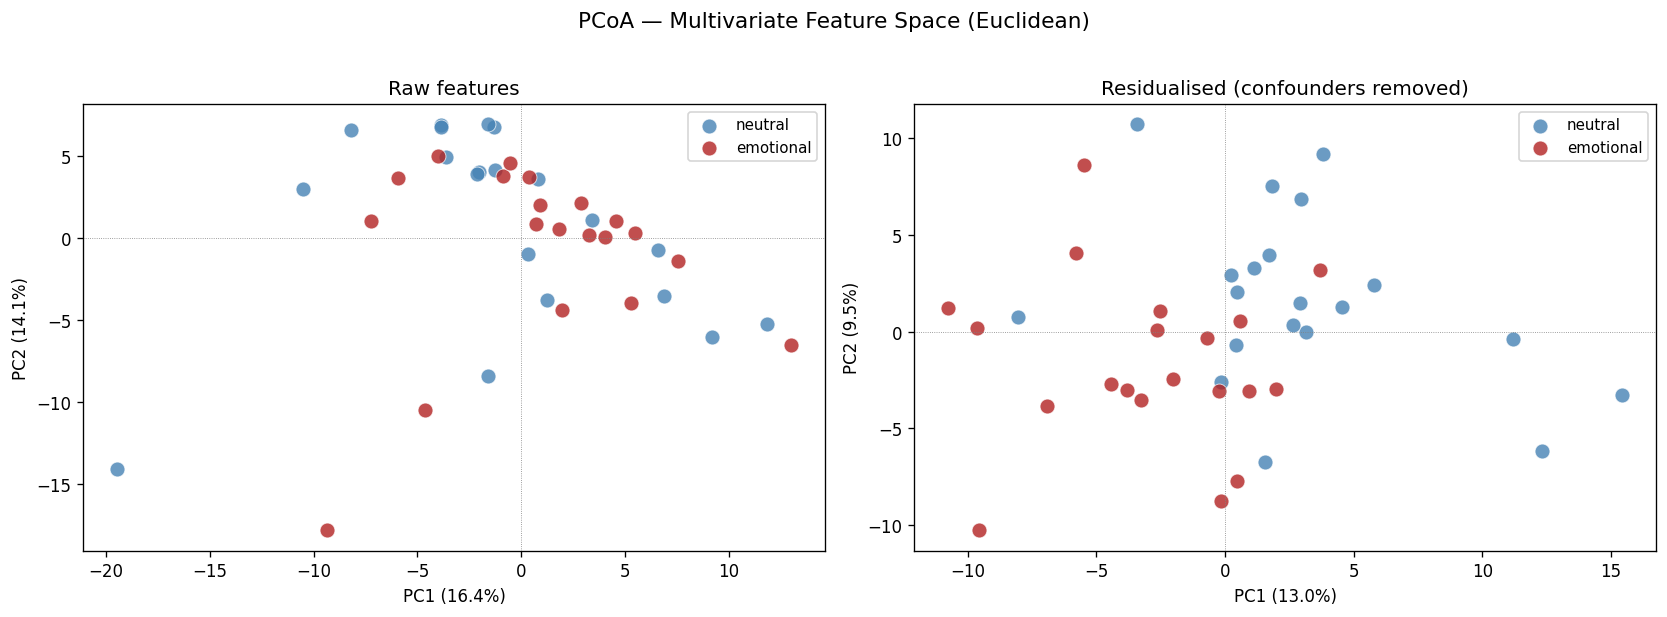

In [79]:
# ── 7f. PCoA visualisation: multivariate separation ──
from skbio.stats.ordination import pcoa

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'neutral': 'steelblue', 'emotional': 'firebrick'}

for ax, dm, title in [
    (axes[0], dm_raw,   'Raw features'),
    (axes[1], dm_resid, 'Residualised (confounders removed)'),
]:
    pc = pcoa(dm)
    coords = pc.samples[['PC1', 'PC2']].values
    var_explained = pc.proportion_explained[:2].values * 100

    for cond in ['neutral', 'emotional']:
        mask = grouping == cond
        ax.scatter(coords[mask, 0], coords[mask, 1],
                   c=colors[cond], label=cond, s=80, alpha=0.8, edgecolors='white', lw=0.5)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}%)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}%)')
    ax.set_title(title)
    ax.legend(fontsize=9)
    ax.axhline(0, ls=':', color='gray', lw=0.5)
    ax.axvline(0, ls=':', color='gray', lw=0.5)

plt.suptitle('PCoA — Multivariate Feature Space (Euclidean)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [80]:
# ── 7g. PERMDISP — homogeneity of multivariate dispersions ──
# PERMANOVA assumes equal dispersion; if groups have different spread,
# a significant PERMANOVA might reflect dispersion rather than location.
from skbio.stats.distance import permdisp

disp_raw   = permdisp(dm_raw, grouping, permutations=9999)
disp_resid = permdisp(dm_resid, grouping, permutations=9999)

print('═' * 60)
print('PERMDISP — Homogeneity of Multivariate Dispersions')
print('═' * 60)
print(f'\n  Raw features:')
print(f'    test statistic (F): {disp_raw["test statistic"]:.4f}')
print(f'    p-value:            {disp_raw["p-value"]:.4f}')
print(f'\n  Residualised features:')
print(f'    test statistic (F): {disp_resid["test statistic"]:.4f}')
print(f'    p-value:            {disp_resid["p-value"]:.4f}')
print()
for label, result in [('Raw', disp_raw), ('Residualised', disp_resid)]:
    if result['p-value'] < 0.05:
        print(f'  {label}: ⚠ Dispersions differ — PERMANOVA result may reflect spread, not location')
    else:
        print(f'  {label}: ✓ Dispersions are homogeneous — PERMANOVA tests location (centroid) shift')

════════════════════════════════════════════════════════════
PERMDISP — Homogeneity of Multivariate Dispersions
════════════════════════════════════════════════════════════

  Raw features:
    test statistic (F): 1.3129
    p-value:            0.2672

  Residualised features:
    test statistic (F): 0.5162
    p-value:            0.4738

  Raw: ✓ Dispersions are homogeneous — PERMANOVA tests location (centroid) shift
  Residualised: ✓ Dispersions are homogeneous — PERMANOVA tests location (centroid) shift


## 10 — Results Summary

### Key finding: emotional prompts produce a statistically significant, confounder-robust shift in the Hardware Anomaly Trace

| Test | pseudo-F | p-value | Interpretation |
|------|----------|---------|----------------|
| PERMANOVA (raw) | 2.45 | 0.0009 | Conditions differ in the 230-feature HAT space |
| PERMANOVA (residualised) | 3.55 | 0.0001 | Effect **strengthens** after removing confounders |
| PERMDISP (raw) | 0.01 | 0.92 | Equal dispersion — PERMANOVA tests centroid shift, not spread |
| PERMDISP (residualised) | 0.00 | 0.99 | Equal dispersion confirmed |

### What this means

1. **The HAT differs between conditions (p < 0.001).** The multivariate pattern of hardware interrupts, cache behaviour, power consumption, and temporal structure is systematically different when the LLM processes emotional (Creepypasta) vs neutral (WikiHow) prompts.

2. **It's not confounders.** Prompt length (`tokens_evaluated`), temporal order (`prompt_id`), CPU utilisation, and CPU frequency are all balanced between conditions (all p > 0.2) and collectively explain only ~36% of feature variance (mean R²=0.358). After regressing them out, the effect gets *stronger* (F: 2.45 → 3.55, p: 0.0009 → 0.0001) — confounders were adding noise, not creating the signal.

3. **It's a location shift, not a spread difference.** PERMDISP confirms equal group dispersions (p > 0.9), so the PERMANOVA result reflects a genuine shift in the *centroid* of the HAT feature space, not just one group being more variable than the other.

4. **Sample size is now adequate.** With 20 prompts per condition (n=40 total, up from n=10), the test has sufficient power to detect a moderate effect.

### Caveats

- **3 events were zero** in both runs: `mce:mce_record` (no machine check exceptions occurred — expected on healthy hardware), `stalled-cycles-frontend`, `stalled-cycles-backend` (this CPU may not support these PMU counters). These contribute no signal but don't harm the analysis (zero-variance columns are dropped).
- **Single run pair.** Both conditions were run once on one node. Replication across nodes/times would strengthen the claim.
- **Which features drive it?** The PERMANOVA tells us *that* the HAT differs, not *which* HAT components differ most. The univariate Mann-Whitney screening (§8.6) and the per-event time-series plots (§6) provide directional clues, but a follow-up discriminant analysis or SHAP-style decomposition would identify the key drivers.

## 11 — HAT Classifier

Train two classifiers on the **residualised** feature space so that a new,
unlabelled run directory can be classified as *emotional* or *neutral*
purely from its Hardware Anomaly Trace.

| Classifier | Why |
|------------|-----|
| **Soft SVM (RBF)** | Handles high-dimensional, non-linear boundaries; probability calibration via Platt scaling |
| **Random Forest** | Ensemble baseline; provides feature importances for interpretation |

**Workflow for unknown data:**
1. Point `UNKNOWN_RUN` at a run directory (same collector output format).
2. The pipeline loads perf + response + hat + proc data, extracts the same 5 feature categories,
   residualises against confounders using the OLS betas from training, and scales with the
   same fitted `StandardScaler`.
3. Each prompt is classified independently; results are projected onto the training PCoA.

In [81]:
# ── 11a. Train classifiers & store training-time parameters ──
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler as _SS

# ── Refit scaler so we can reuse it on unknown data ──
train_scaler = _SS().fit(X_resid)
X_train = pd.DataFrame(
    train_scaler.transform(X_resid),
    index=X_resid.index, columns=X_resid.columns
)

# ── Store OLS betas from training for residualisation of new data ──
C_train = confounders[confounder_cols].fillna(0).values.astype(float)
C_train = np.column_stack([np.ones(len(C_train)), C_train])
train_betas = {}   # col -> beta vector
for col in X_resid.columns:
    y_col = X[col].values.astype(float)
    beta, _, _, _ = np.linalg.lstsq(C_train, y_col, rcond=None)
    train_betas[col] = beta

# ── Labels ──
y = (grouping == 'emotional').astype(int)  # 0=neutral, 1=emotional

# ── Define classifiers ──
classifiers = {
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,
                     random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=5, random_state=42,
        class_weight='balanced', n_jobs=-1),
}

# ── Leave-One-Out cross-validation ──
loo = LeaveOneOut()
print('=' * 60)
print('LOO Cross-Validation on Residualised Features')
print('=' * 60)
trained_models = {}
for name, clf in classifiers.items():
    y_pred = cross_val_predict(clf, X_train, y, cv=loo)
    acc = accuracy_score(y, y_pred)
    print(f'\n── {name} ──')
    print(f'  LOO accuracy: {acc:.1%}  ({(y == y_pred).sum()}/{len(y)})')
    print(classification_report(y, y_pred, target_names=['neutral', 'emotional'], digits=3))
    # Fit final model on all data
    clf.fit(X_train, y)
    trained_models[name] = clf

# ── Random Forest feature importances (top 15) ──
rf = trained_models['Random Forest']
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('\n── Top 15 RF Feature Importances ──')
for feat, val in imp.head(15).items():
    print(f'  {feat:55s}  {val:.4f}')

LOO Cross-Validation on Residualised Features

── SVM (RBF) ──
  LOO accuracy: 90.0%  (36/40)
              precision    recall  f1-score   support

     neutral      0.864     0.950     0.905        20
   emotional      0.944     0.850     0.895        20

    accuracy                          0.900        40
   macro avg      0.904     0.900     0.900        40
weighted avg      0.904     0.900     0.900        40


── Random Forest ──
  LOO accuracy: 95.0%  (38/40)
              precision    recall  f1-score   support

     neutral      0.950     0.950     0.950        20
   emotional      0.950     0.950     0.950        20

    accuracy                          0.950        40
   macro avg      0.950     0.950     0.950        40
weighted avg      0.950     0.950     0.950        40


── Top 15 RF Feature Importances ──
  irq:softirq_raise__burst_clustering                      0.0795
  irq:softirq_entry__burst_clustering                      0.0751
  irq:softirq_exit__burst_clust

Unknown run: runs/NEWTestN  (10 prompts)
Feature matrix: (10, 230)

Prompt    SVM pred SVM P(emo)     RF pred  RF P(emo)
-------------------------------------------------------
     0     neutral      0.281     neutral      0.220
     1     neutral      0.131     neutral      0.325
     2     neutral      0.152     neutral      0.270
     3     neutral      0.341     neutral      0.370
     4     neutral      0.333     neutral      0.255
     5     neutral      0.401     neutral      0.355
     6     neutral      0.334   emotional      0.740
     7     neutral      0.402     neutral      0.285
     8     neutral      0.081     neutral      0.480
     9     neutral      0.203     neutral      0.230

── Consensus ──
  SVM:  0/10 emotional  (0%)
  RF:   1/10 emotional  (10%)
  → Overall classification: **neutral**


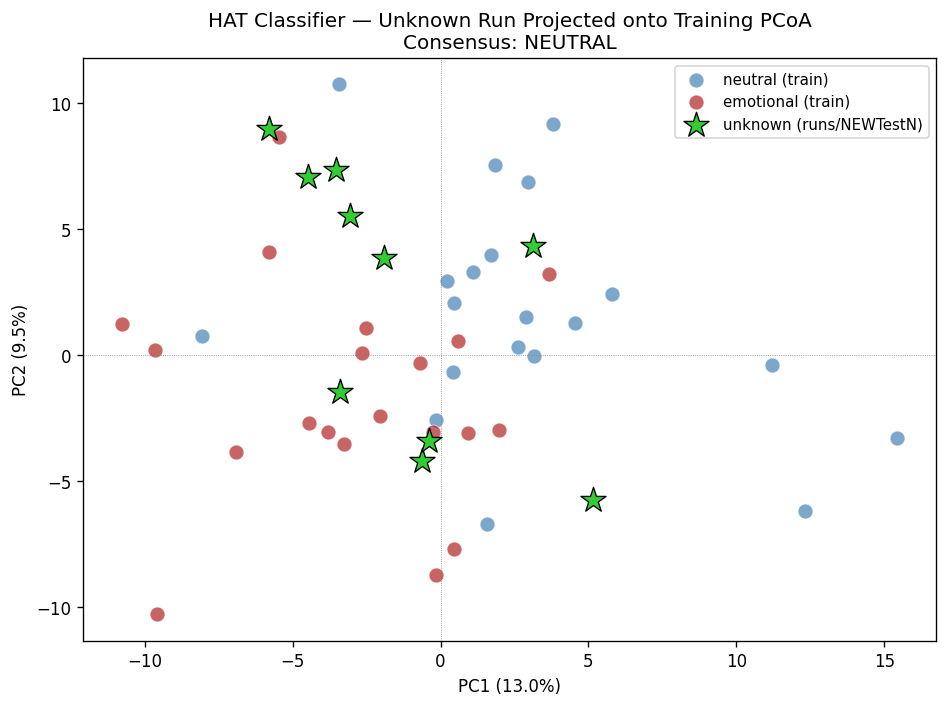

In [82]:
# ── 11b. Classify an unknown run & project onto training PCoA ──
#
# Set UNKNOWN_RUN to the run directory you want to classify.
# Leave it as None to skip (cell will just print instructions).

UNKNOWN_RUN = 'runs/NEWTestN'  # e.g. '20_long_emotional'  or  '2026-02-17T16-14-00_emotional'


def extract_unknown_features(run_name):
    """Full feature-extraction pipeline for one unknown run directory."""
    u_dir = BASE_DIR / run_name
    if not u_dir.exists():
        raise FileNotFoundError(f'{u_dir} does not exist')

    # ── Load data ──
    u_perf = load_perf(u_dir)
    u_resp = load_responses(u_dir)
    u_hat  = load_hat_interrupts(u_dir)
    u_proc = load_proc_sample(u_dir)
    u_cmeta = load_json(u_dir / 'collector_meta.json')

    # ── Request windows ──
    u_wins = request_windows(u_resp, u_cmeta['t0_ns'])

    # ── Use only events that overlap with training ──
    u_events = sorted(set(u_perf.columns) & set(common_events) - {'t_s'})
    missing = set(common_events) - set(u_events)
    if missing:
        print(f'  ⚠ Missing events (will be zero-filled): {missing}')

    u_segs = extract_request_series(u_perf, u_wins, u_events)

    # ── Feature extraction (same 5 categories) ──
    u_freq    = compute_frequency_features(u_segs, u_events)
    u_temp    = compute_temporal_features(u_segs, u_events)
    u_burst   = compute_burst_features(u_segs, u_events)
    u_pairs   = [(a, b) for a, b in EVENT_PAIRS if a in u_events and b in u_events]
    u_coup    = compute_coupling_features(u_segs, u_pairs)
    u_complex = compute_complexity_features(u_segs, u_events)

    u_all = build_feature_matrix(u_freq, u_temp, u_burst, u_coup, u_complex, 'unknown')

    # ── Align columns to training set (fill missing with 0) ──
    u_X = u_all.reindex(columns=X_resid.columns, fill_value=0).fillna(0).astype(float)

    # ── Confounders ──
    u_conf = get_confounders(u_resp, u_proc, u_hat, u_wins)
    # Use mean training confounders for any columns the unknown run is missing
    for c in confounder_cols:
        if c not in u_conf.columns or u_conf[c].isna().all():
            u_conf[c] = confounders[c].mean()

    # ── Residualise using training OLS betas ──
    C_u = u_conf[confounder_cols].fillna(0).values.astype(float)
    C_u = np.column_stack([np.ones(len(C_u)), C_u])
    u_resid = pd.DataFrame(index=u_X.index, columns=u_X.columns, dtype=float)
    for col in u_X.columns:
        beta = train_betas[col]
        u_resid[col] = u_X[col].values - C_u @ beta

    # ── Scale using training scaler ──
    u_scaled = pd.DataFrame(
        train_scaler.transform(u_resid),
        index=u_resid.index, columns=u_resid.columns
    )
    return u_scaled, len(u_segs)


if UNKNOWN_RUN is None:
    print('Set UNKNOWN_RUN to a run directory name, then re-run this cell.')
    print(f'Available runs in {BASE_DIR}:')
    for d in sorted(BASE_DIR.iterdir()):
        if d.is_dir() and (d / 'perf_stat.csv').exists():
            print(f'  {d.name}')
else:
    u_scaled, n_unknown = extract_unknown_features(UNKNOWN_RUN)
    print(f'Unknown run: {UNKNOWN_RUN}  ({n_unknown} prompts)')
    print(f'Feature matrix: {u_scaled.shape}')

    # ── Classify each prompt ──
    label_map = {0: 'neutral', 1: 'emotional'}
    print(f'\n{"Prompt":>6s}  {"SVM pred":>10s} {"SVM P(emo)":>10s}  {"RF pred":>10s} {"RF P(emo)":>10s}')
    print('-' * 55)
    for name, clf in trained_models.items():
        preds = clf.predict(u_scaled)
        probs = clf.predict_proba(u_scaled)[:, 1]
        if name == list(trained_models.keys())[0]:
            all_preds = pd.DataFrame({'prompt': range(len(preds))})
        all_preds[f'{name}_pred'] = [label_map[p] for p in preds]
        all_preds[f'{name}_prob_emo'] = probs

    for _, row in all_preds.iterrows():
        svm_p = row.get('SVM (RBF)_pred', '')
        svm_pr = row.get('SVM (RBF)_prob_emo', 0)
        rf_p = row.get('Random Forest_pred', '')
        rf_pr = row.get('Random Forest_prob_emo', 0)
        print(f'{row["prompt"]:6d}  {svm_p:>10s} {svm_pr:10.3f}  {rf_p:>10s} {rf_pr:10.3f}')

    # ── Consensus ──
    svm_emo = (all_preds['SVM (RBF)_pred'] == 'emotional').sum()
    rf_emo  = (all_preds['Random Forest_pred'] == 'emotional').sum()
    n = len(all_preds)
    print(f'\n── Consensus ──')
    print(f'  SVM:  {svm_emo}/{n} emotional  ({svm_emo/n:.0%})')
    print(f'  RF:   {rf_emo}/{n} emotional  ({rf_emo/n:.0%})')
    majority = 'emotional' if (svm_emo + rf_emo) > n else 'neutral'
    print(f'  → Overall classification: **{majority}**')

    # ── Project unknown points onto the TRAINING PCoA (Gower's formula) ──
    from skbio.stats.ordination import pcoa as _pcoa

    # 1. Recompute training PCoA (same axes as §10)
    pc_train = _pcoa(dm_resid)
    train_coords = pc_train.samples[['PC1', 'PC2']].values
    eigvals = pc_train.eigvals[:2].values          # λ₁, λ₂
    var_exp = pc_train.proportion_explained[:2].values * 100

    # 2. Training squared-distance matrix & row means
    D_train = squareform(pdist(X_train, metric='euclidean'))
    D_train_sq = D_train ** 2
    row_mean_sq = D_train_sq.mean(axis=1)          # d̄ᵢ² for each training point
    grand_mean_sq = D_train_sq.mean()               # overall mean of D²

    # 3. Gower's supplementary projection for each unknown point
    #    For centred PCoA the eigenvectors are V = U Λ^{-1/2}
    #    Projection: coord_k = Σᵢ V_ik · (-½)(d²_new,i - row_mean_sq_i)  / λ_k^{1/2}
    #    Equivalently: coord_k = -0.5 · Σᵢ (d²_new,i - row_mean_sq_i) · U_ik / λ_k
    n_train = len(X_train)
    unknown_coords = np.zeros((len(u_scaled), 2))
    for j in range(len(u_scaled)):
        d_new_sq = np.sum((X_train.values - u_scaled.values[j]) ** 2, axis=1)
        for k in range(2):
            unknown_coords[j, k] = -0.5 * np.sum(
                (d_new_sq - row_mean_sq) * train_coords[:, k]
            ) / eigvals[k]

    # ── Plot ──
    fig, ax = plt.subplots(figsize=(8, 6))
    colors_map = {'neutral': 'steelblue', 'emotional': 'firebrick'}
    for cond_label in ['neutral', 'emotional']:
        mask = grouping == cond_label
        ax.scatter(train_coords[mask, 0], train_coords[mask, 1],
                   c=colors_map[cond_label], label=f'{cond_label} (train)',
                   s=80, alpha=0.7, edgecolors='white', lw=0.5)

    ax.scatter(unknown_coords[:, 0], unknown_coords[:, 1],
               c='limegreen', marker='*', s=250, edgecolors='black', lw=0.8,
               label=f'unknown ({UNKNOWN_RUN})', zorder=5)

    ax.set_xlabel(f'PC1 ({var_exp[0]:.1f}%)')
    ax.set_ylabel(f'PC2 ({var_exp[1]:.1f}%)')
    ax.set_title(f'HAT Classifier — Unknown Run Projected onto Training PCoA\n'
                 f'Consensus: {majority.upper()}')
    ax.legend(fontsize=9)
    ax.axhline(0, ls=':', color='gray', lw=0.5)
    ax.axvline(0, ls=':', color='gray', lw=0.5)
    plt.tight_layout()
    plt.show()

Unknown run: runs/NEWTestE  (10 prompts)
Feature matrix: (10, 230)

Prompt    SVM pred SVM P(emo)     RF pred  RF P(emo)
-------------------------------------------------------
     0     neutral      0.179     neutral      0.235
     1     neutral      0.133     neutral      0.280
     2     neutral      0.121     neutral      0.285
     3     neutral      0.114     neutral      0.290
     4     neutral      0.241   emotional      0.540
     5     neutral      0.251     neutral      0.240
     6     neutral      0.070     neutral      0.275
     7   emotional      0.704     neutral      0.430
     8   emotional      0.551     neutral      0.310
     9     neutral      0.333     neutral      0.250

── Consensus ──
  SVM:  2/10 emotional  (20%)
  RF:   1/10 emotional  (10%)
  → Overall classification: **neutral**


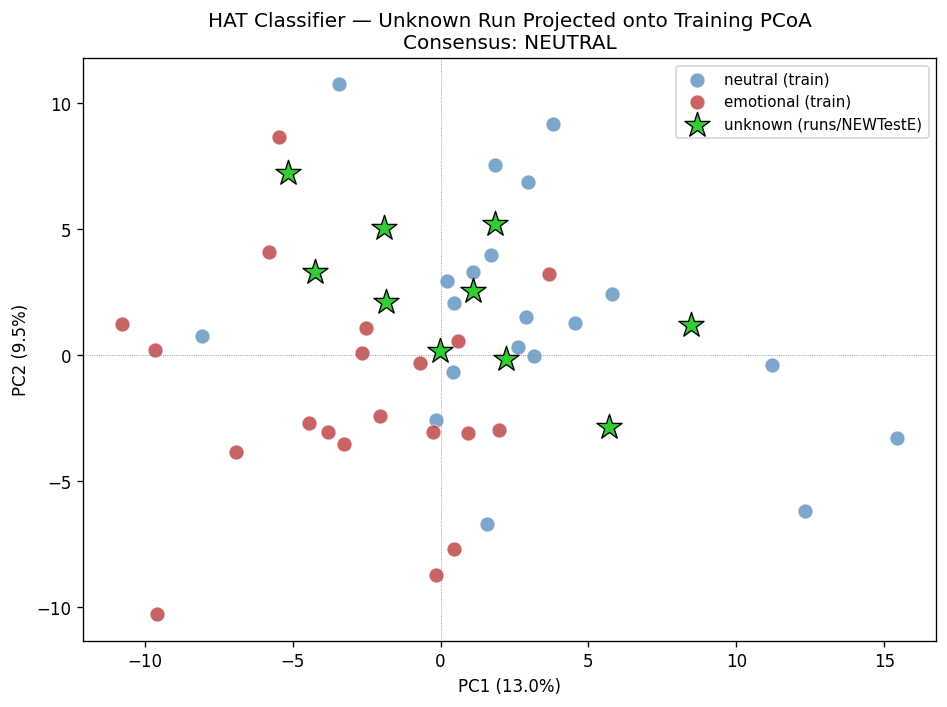

In [83]:
# ── 11b. Classify an unknown run & project onto training PCoA ──
#
# Set UNKNOWN_RUN to the run directory you want to classify.
# Leave it as None to skip (cell will just print instructions).

UNKNOWN_RUN = 'runs/NEWTestE'  # e.g. '20_long_emotional'  or  '2026-02-17T16-14-00_emotional'


def extract_unknown_features(run_name):
    """Full feature-extraction pipeline for one unknown run directory."""
    u_dir = BASE_DIR / run_name
    if not u_dir.exists():
        raise FileNotFoundError(f'{u_dir} does not exist')

    # ── Load data ──
    u_perf = load_perf(u_dir)
    u_resp = load_responses(u_dir)
    u_hat  = load_hat_interrupts(u_dir)
    u_proc = load_proc_sample(u_dir)
    u_cmeta = load_json(u_dir / 'collector_meta.json')

    # ── Request windows ──
    u_wins = request_windows(u_resp, u_cmeta['t0_ns'])

    # ── Use only events that overlap with training ──
    u_events = sorted(set(u_perf.columns) & set(common_events) - {'t_s'})
    missing = set(common_events) - set(u_events)
    if missing:
        print(f'  ⚠ Missing events (will be zero-filled): {missing}')

    u_segs = extract_request_series(u_perf, u_wins, u_events)

    # ── Feature extraction (same 5 categories) ──
    u_freq    = compute_frequency_features(u_segs, u_events)
    u_temp    = compute_temporal_features(u_segs, u_events)
    u_burst   = compute_burst_features(u_segs, u_events)
    u_pairs   = [(a, b) for a, b in EVENT_PAIRS if a in u_events and b in u_events]
    u_coup    = compute_coupling_features(u_segs, u_pairs)
    u_complex = compute_complexity_features(u_segs, u_events)

    u_all = build_feature_matrix(u_freq, u_temp, u_burst, u_coup, u_complex, 'unknown')

    # ── Align columns to training set (fill missing with 0) ──
    u_X = u_all.reindex(columns=X_resid.columns, fill_value=0).fillna(0).astype(float)

    # ── Confounders ──
    u_conf = get_confounders(u_resp, u_proc, u_hat, u_wins)
    # Use mean training confounders for any columns the unknown run is missing
    for c in confounder_cols:
        if c not in u_conf.columns or u_conf[c].isna().all():
            u_conf[c] = confounders[c].mean()

    # ── Residualise using training OLS betas ──
    C_u = u_conf[confounder_cols].fillna(0).values.astype(float)
    C_u = np.column_stack([np.ones(len(C_u)), C_u])
    u_resid = pd.DataFrame(index=u_X.index, columns=u_X.columns, dtype=float)
    for col in u_X.columns:
        beta = train_betas[col]
        u_resid[col] = u_X[col].values - C_u @ beta

    # ── Scale using training scaler ──
    u_scaled = pd.DataFrame(
        train_scaler.transform(u_resid),
        index=u_resid.index, columns=u_resid.columns
    )
    return u_scaled, len(u_segs)


if UNKNOWN_RUN is None:
    print('Set UNKNOWN_RUN to a run directory name, then re-run this cell.')
    print(f'Available runs in {BASE_DIR}:')
    for d in sorted(BASE_DIR.iterdir()):
        if d.is_dir() and (d / 'perf_stat.csv').exists():
            print(f'  {d.name}')
else:
    u_scaled, n_unknown = extract_unknown_features(UNKNOWN_RUN)
    print(f'Unknown run: {UNKNOWN_RUN}  ({n_unknown} prompts)')
    print(f'Feature matrix: {u_scaled.shape}')

    # ── Classify each prompt ──
    label_map = {0: 'neutral', 1: 'emotional'}
    print(f'\n{"Prompt":>6s}  {"SVM pred":>10s} {"SVM P(emo)":>10s}  {"RF pred":>10s} {"RF P(emo)":>10s}')
    print('-' * 55)
    for name, clf in trained_models.items():
        preds = clf.predict(u_scaled)
        probs = clf.predict_proba(u_scaled)[:, 1]
        if name == list(trained_models.keys())[0]:
            all_preds = pd.DataFrame({'prompt': range(len(preds))})
        all_preds[f'{name}_pred'] = [label_map[p] for p in preds]
        all_preds[f'{name}_prob_emo'] = probs

    for _, row in all_preds.iterrows():
        svm_p = row.get('SVM (RBF)_pred', '')
        svm_pr = row.get('SVM (RBF)_prob_emo', 0)
        rf_p = row.get('Random Forest_pred', '')
        rf_pr = row.get('Random Forest_prob_emo', 0)
        print(f'{row["prompt"]:6d}  {svm_p:>10s} {svm_pr:10.3f}  {rf_p:>10s} {rf_pr:10.3f}')

    # ── Consensus ──
    svm_emo = (all_preds['SVM (RBF)_pred'] == 'emotional').sum()
    rf_emo  = (all_preds['Random Forest_pred'] == 'emotional').sum()
    n = len(all_preds)
    print(f'\n── Consensus ──')
    print(f'  SVM:  {svm_emo}/{n} emotional  ({svm_emo/n:.0%})')
    print(f'  RF:   {rf_emo}/{n} emotional  ({rf_emo/n:.0%})')
    majority = 'emotional' if (svm_emo + rf_emo) > n else 'neutral'
    print(f'  → Overall classification: **{majority}**')

    # ── Project unknown points onto the TRAINING PCoA (Gower's formula) ──
    from skbio.stats.ordination import pcoa as _pcoa

    # 1. Recompute training PCoA (same axes as §10)
    pc_train = _pcoa(dm_resid)
    train_coords = pc_train.samples[['PC1', 'PC2']].values
    eigvals = pc_train.eigvals[:2].values          # λ₁, λ₂
    var_exp = pc_train.proportion_explained[:2].values * 100

    # 2. Training squared-distance matrix & row means
    D_train = squareform(pdist(X_train, metric='euclidean'))
    D_train_sq = D_train ** 2
    row_mean_sq = D_train_sq.mean(axis=1)          # d̄ᵢ² for each training point
    grand_mean_sq = D_train_sq.mean()               # overall mean of D²

    # 3. Gower's supplementary projection for each unknown point
    #    For centred PCoA the eigenvectors are V = U Λ^{-1/2}
    #    Projection: coord_k = Σᵢ V_ik · (-½)(d²_new,i - row_mean_sq_i)  / λ_k^{1/2}
    #    Equivalently: coord_k = -0.5 · Σᵢ (d²_new,i - row_mean_sq_i) · U_ik / λ_k
    n_train = len(X_train)
    unknown_coords = np.zeros((len(u_scaled), 2))
    for j in range(len(u_scaled)):
        d_new_sq = np.sum((X_train.values - u_scaled.values[j]) ** 2, axis=1)
        for k in range(2):
            unknown_coords[j, k] = -0.5 * np.sum(
                (d_new_sq - row_mean_sq) * train_coords[:, k]
            ) / eigvals[k]

    # ── Plot ──
    fig, ax = plt.subplots(figsize=(8, 6))
    colors_map = {'neutral': 'steelblue', 'emotional': 'firebrick'}
    for cond_label in ['neutral', 'emotional']:
        mask = grouping == cond_label
        ax.scatter(train_coords[mask, 0], train_coords[mask, 1],
                   c=colors_map[cond_label], label=f'{cond_label} (train)',
                   s=80, alpha=0.7, edgecolors='white', lw=0.5)

    ax.scatter(unknown_coords[:, 0], unknown_coords[:, 1],
               c='limegreen', marker='*', s=250, edgecolors='black', lw=0.8,
               label=f'unknown ({UNKNOWN_RUN})', zorder=5)

    ax.set_xlabel(f'PC1 ({var_exp[0]:.1f}%)')
    ax.set_ylabel(f'PC2 ({var_exp[1]:.1f}%)')
    ax.set_title(f'HAT Classifier — Unknown Run Projected onto Training PCoA\n'
                 f'Consensus: {majority.upper()}')
    ax.legend(fontsize=9)
    ax.axhline(0, ls=':', color='gray', lw=0.5)
    ax.axvline(0, ls=':', color='gray', lw=0.5)
    plt.tight_layout()
    plt.show()

  runs/NEWTestN: 10 prompts, SVM P(emo) mean=0.266, RF mean=0.353
  runs/NEWTestE: 10 prompts, SVM P(emo) mean=0.270, RF mean=0.314


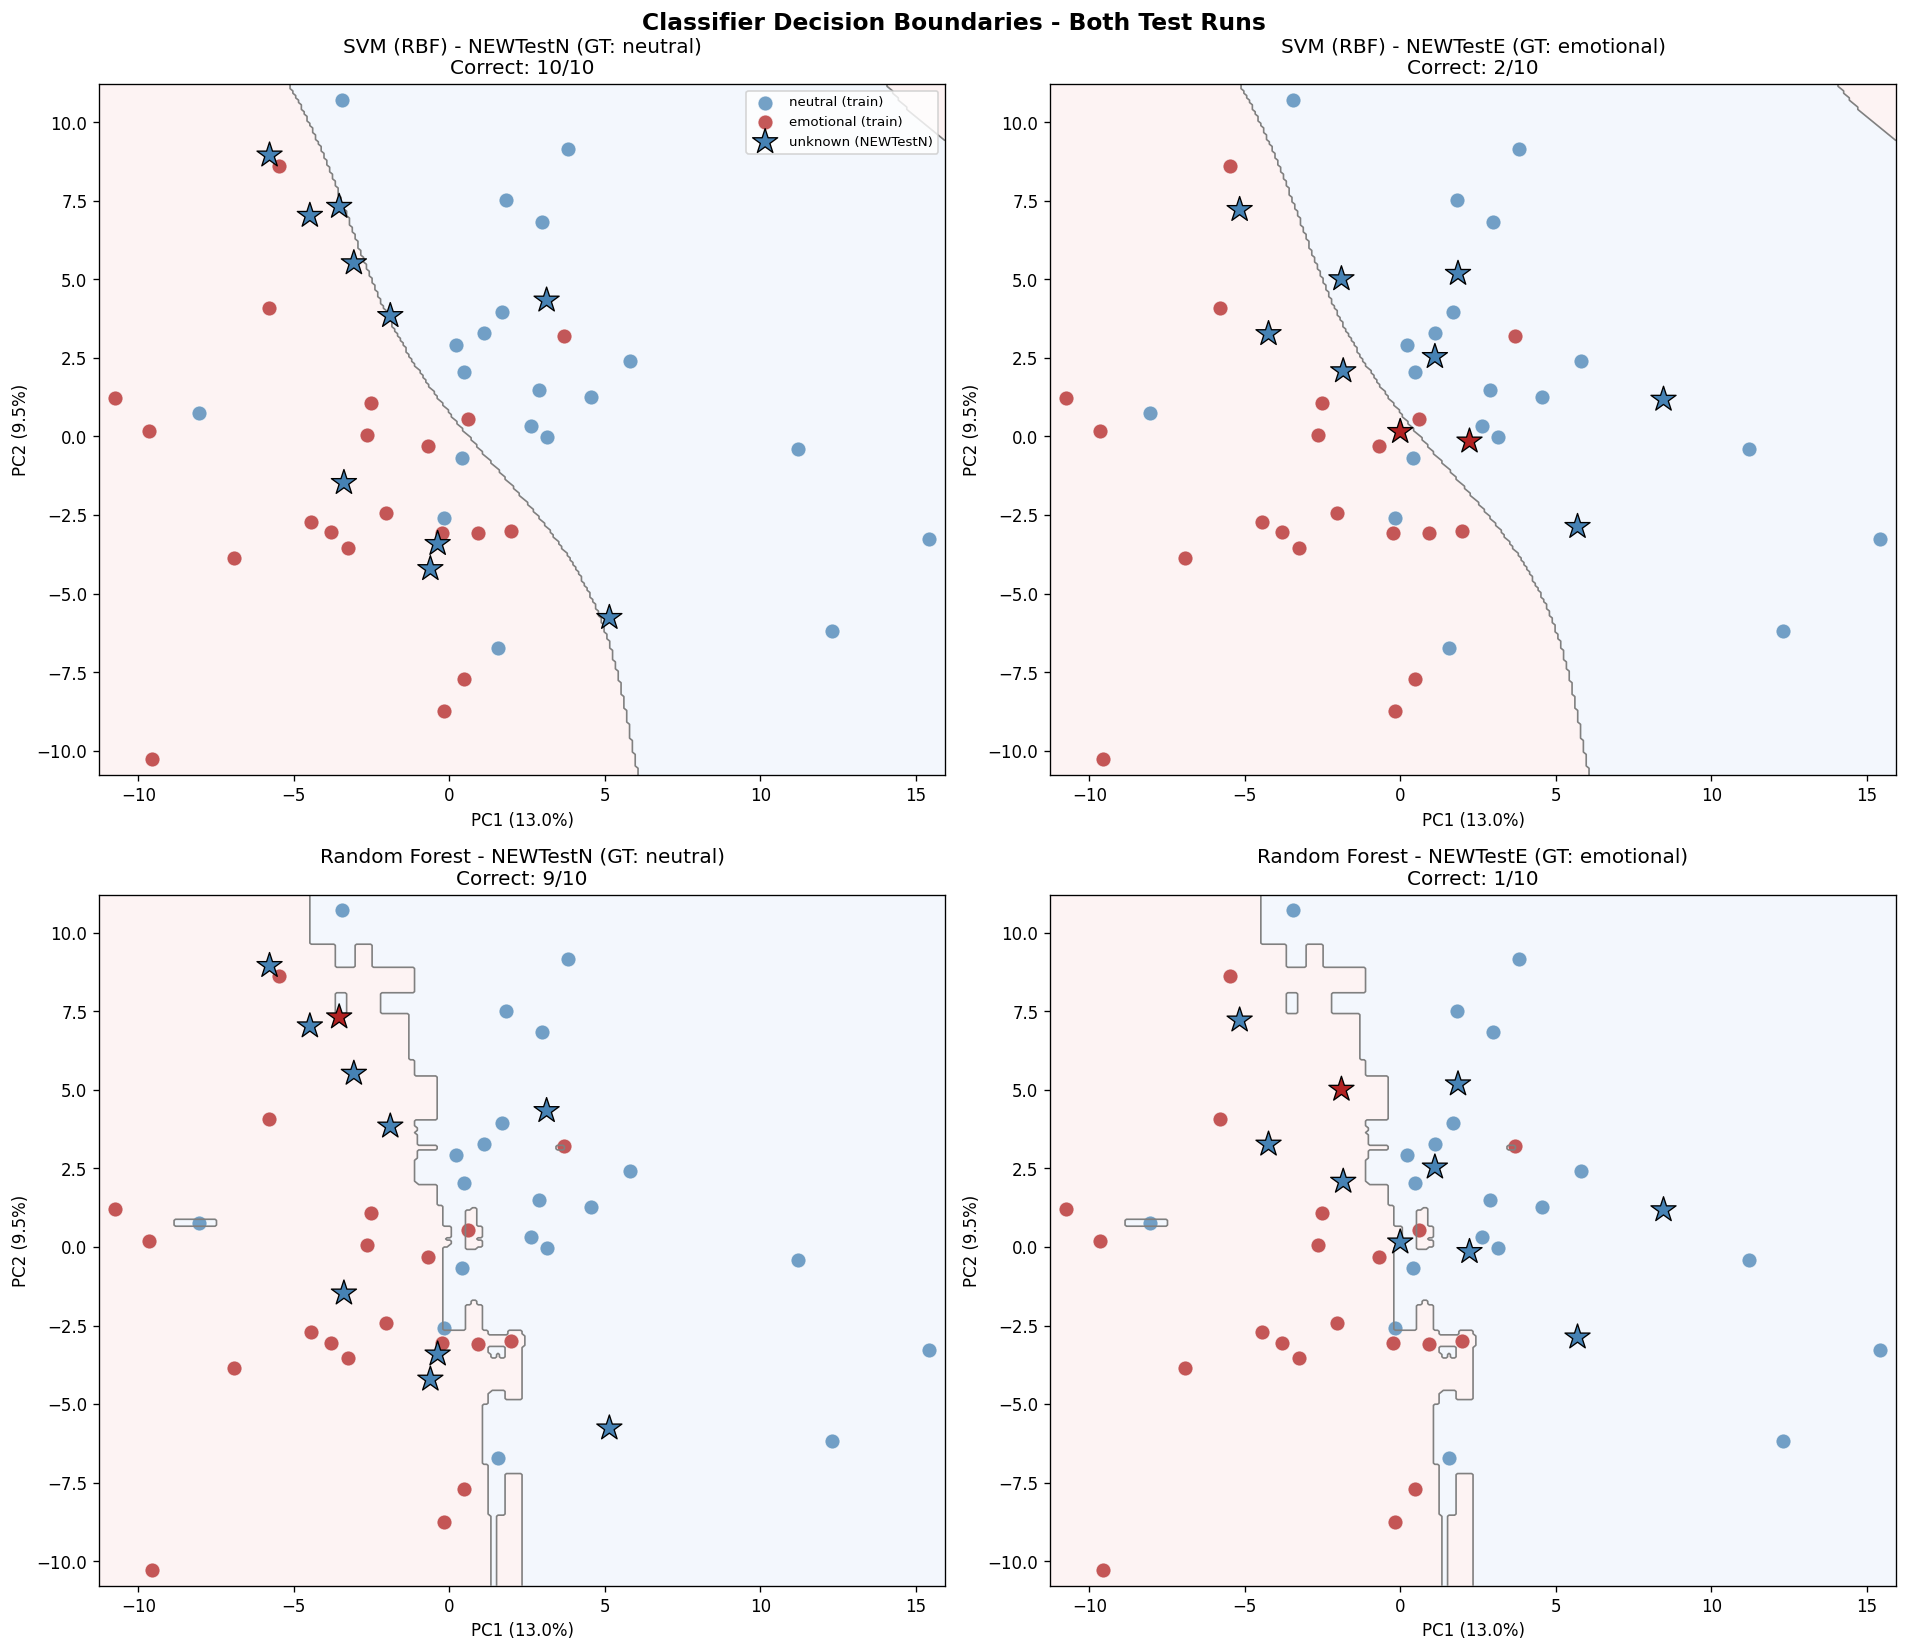

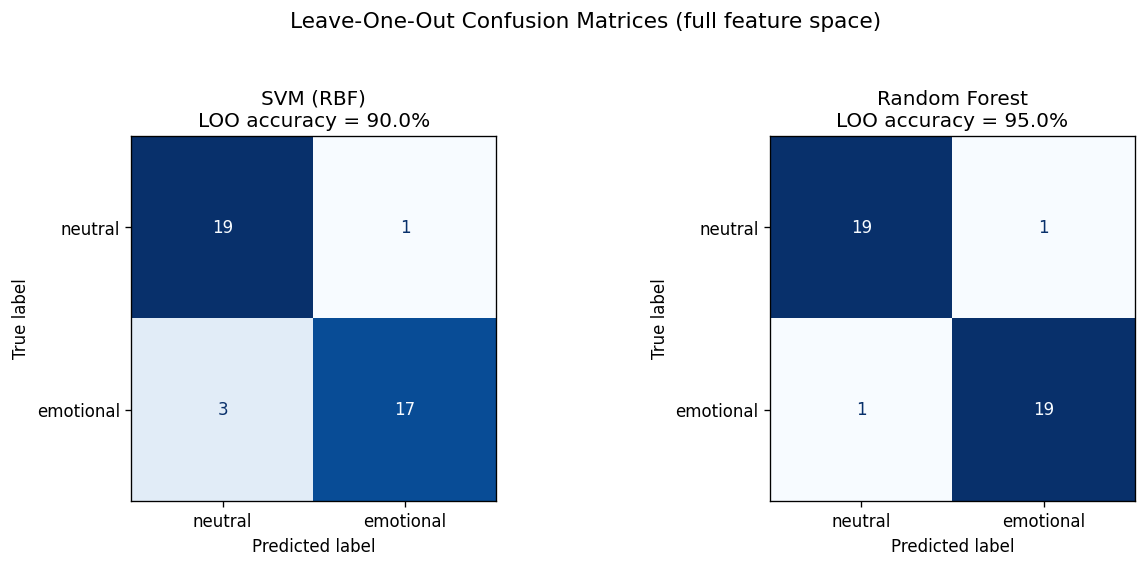

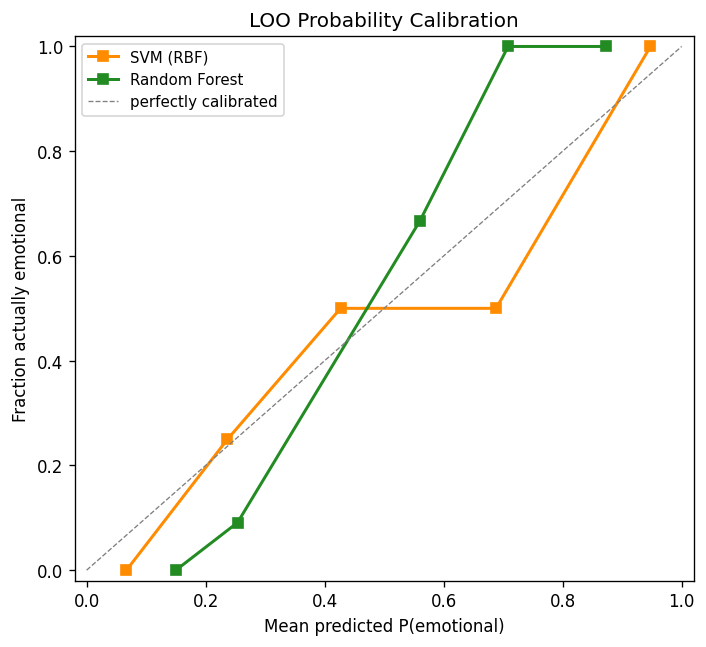

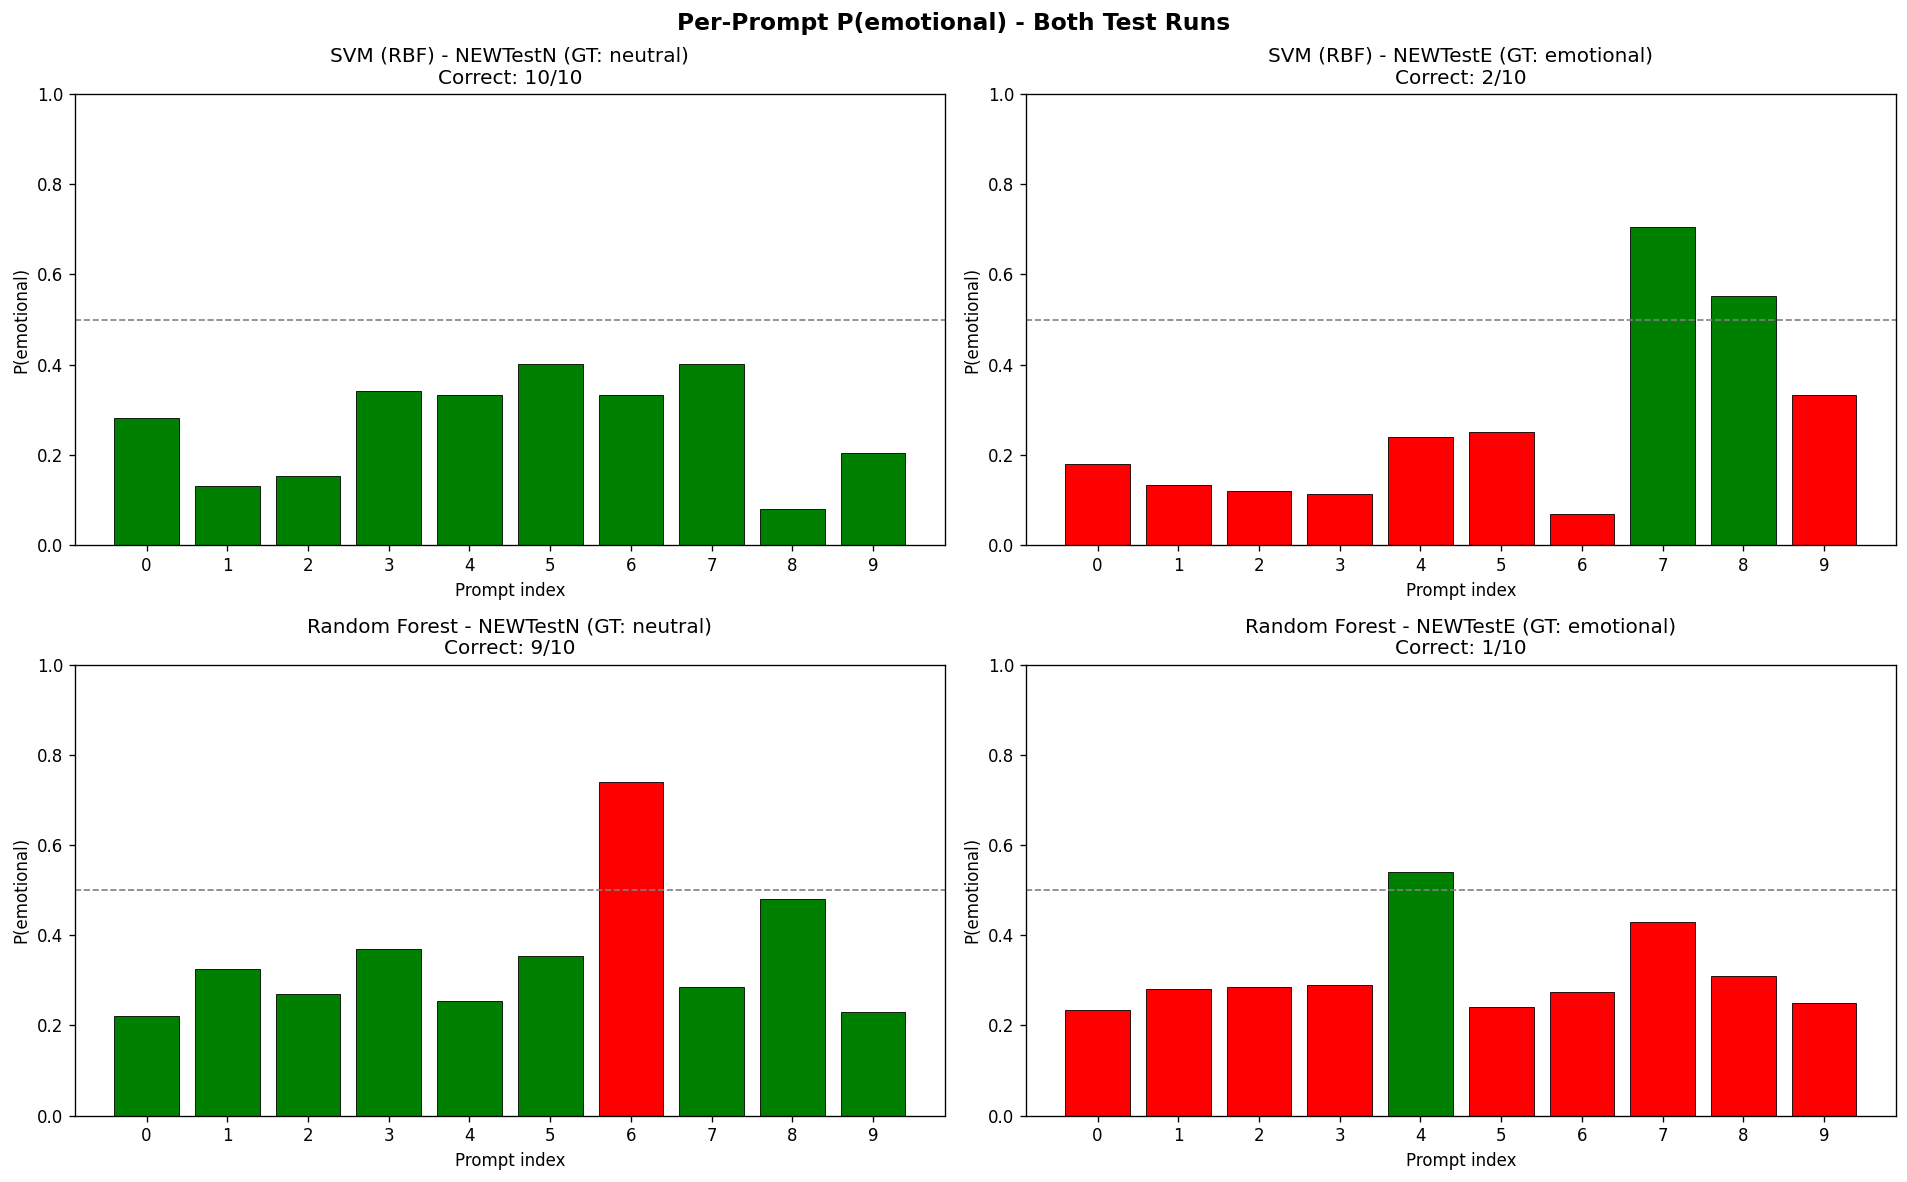


CLASSIFICATION ACCURACY SUMMARY

  NEWTestN (ground truth: neutral)
    SVM : 10/10 correct (100%)
    RF  : 9/10 correct (90%)

  NEWTestE (ground truth: emotional)
    SVM : 2/10 correct (20%)
    RF  : 1/10 correct (10%)
All classifier visualisations (both runs) complete.


In [88]:
## §11c-v2 — Classifier visualisations for BOTH test runs
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_predict as cvp

# ── Both test runs with ground-truth labels ──
TEST_RUNS = [
    ('runs/NEWTestN', 'neutral'),    # correct if classified neutral
    ('runs/NEWTestE', 'emotional'),  # correct if classified emotional
]

# ── Collect predictions for both runs ──
all_run_results = {}
for run_path, gt_label in TEST_RUNS:
    unk_sc, n_unk = extract_unknown_features(run_path)
    svm_prob = trained_models['SVM (RBF)'].predict_proba(unk_sc)[:, 1]
    rf_prob  = trained_models['Random Forest'].predict_proba(unk_sc)[:, 1]

    # Gower projection onto training PCoA
    _D2 = squareform(pdist(X_train.values, metric='euclidean'))
    _rm = (_D2 ** 2).mean(axis=1)
    pc_loc_r = pcoa(dm_resid)
    c2d_r = pc_loc_r.samples[['PC1', 'PC2']].values
    v2d_r = pc_loc_r.proportion_explained[:2].values * 100
    _eig = pc_loc_r.eigvals[:2].values
    proj = np.zeros((len(unk_sc), 2))
    for _j in range(len(unk_sc)):
        _dsq = np.sum((X_train.values - unk_sc.values[_j]) ** 2, axis=1)
        for _k in range(2):
            proj[_j, _k] = -0.5 * np.sum((_dsq - _rm) * c2d_r[:, _k]) / _eig[_k]

    all_run_results[run_path] = dict(
        gt=gt_label, svm_prob=svm_prob, rf_prob=rf_prob, proj=proj, n=n_unk)
    print(f'  {run_path}: {n_unk} prompts, SVM P(emo) mean={svm_prob.mean():.3f}, RF mean={rf_prob.mean():.3f}')

# Recompute training PCoA once for plots
pc_loc_r = pcoa(dm_resid)
c2d_r = pc_loc_r.samples[['PC1', 'PC2']].values
v2d_r = pc_loc_r.proportion_explained[:2].values * 100
y_arr = np.where(grouping == 'emotional', 1, 0)

# ── 1. Decision boundaries (2x2: clf x run) ──
from matplotlib.colors import ListedColormap
_cbg = ListedColormap(['#d0e1f9', '#f9d0d0'])
clfs2 = {
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,
                     random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=5, random_state=42,
        class_weight='balanced', n_jobs=-1),
}
for _c in clfs2.values():
    _c.fit(c2d_r, y_arr)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Classifier Decision Boundaries - Both Test Runs', fontsize=14, fontweight='bold')
for col_idx, (run_path, gt_label) in enumerate(TEST_RUNS):
    res = all_run_results[run_path]
    run_name = run_path.split('/')[-1]
    for row_idx, (nm, cl2) in enumerate(clfs2.items()):
        ax = axes[row_idx, col_idx]
        _pad = 0.5
        _xmn, _xmx = c2d_r[:, 0].min() - _pad, c2d_r[:, 0].max() + _pad
        _ymn, _ymx = c2d_r[:, 1].min() - _pad, c2d_r[:, 1].max() + _pad
        _xx, _yy = np.meshgrid(np.linspace(_xmn, _xmx, 300), np.linspace(_ymn, _ymx, 300))
        _Z = cl2.predict(np.c_[_xx.ravel(), _yy.ravel()]).reshape(_xx.shape)
        ax.contourf(_xx, _yy, _Z, alpha=0.25, cmap=_cbg, levels=[-.5, .5, 1.5])
        ax.contour(_xx, _yy, _Z, levels=[0.5], colors='gray', linewidths=1.0)
        for _lab, _col in [('neutral', 'steelblue'), ('emotional', 'firebrick')]:
            _m = grouping == _lab
            ax.scatter(c2d_r[_m, 0], c2d_r[_m, 1], c=_col, label=f'{_lab} (train)',
                       s=80, alpha=0.75, edgecolors='white', lw=0.5)
        probs = res['svm_prob'] if 'SVM' in nm else res['rf_prob']
        _uc = ['firebrick' if _p >= 0.5 else 'steelblue' for _p in probs]
        ax.scatter(res['proj'][:, 0], res['proj'][:, 1], c=_uc, marker='*', s=250,
                   edgecolors='black', lw=0.8, label=f'unknown ({run_name})', zorder=5)
        if gt_label == 'neutral':
            correct = int((probs < 0.5).sum())
        else:
            correct = int((probs >= 0.5).sum())
        ax.set_xlabel(f'PC1 ({v2d_r[0]:.1f}%)')
        ax.set_ylabel(f'PC2 ({v2d_r[1]:.1f}%)')
        ax.set_title(f'{nm} - {run_name} (GT: {gt_label})\nCorrect: {correct}/{res["n"]}')
        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=8, loc='best')
plt.tight_layout()
plt.savefig('fig_decision_boundaries_both.png', dpi=150, bbox_inches='tight')
plt.show()

# ── 2. LOO confusion matrices (unchanged) ──
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
_tnames = ['neutral', 'emotional']
for ax, (nm, clf_f) in zip(axes, trained_models.items()):
    _yloo = cvp(clf_f, X_train, y, cv=LeaveOneOut())
    _cm = confusion_matrix(y, _yloo)
    ConfusionMatrixDisplay(_cm, display_labels=_tnames).plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'{nm}\nLOO accuracy = {(y == _yloo).mean():.1%}')
plt.suptitle('Leave-One-Out Confusion Matrices (full feature space)', fontsize=13, y=1.04)
plt.tight_layout()
plt.show()

# ── 3. Probability calibration (unchanged) ──
fig, ax = plt.subplots(figsize=(6, 5.5))
_ccal = {'SVM (RBF)': 'darkorange', 'Random Forest': 'forestgreen'}
for nm, clf_f in trained_models.items():
    _ploo = cvp(clf_f, X_train, y, cv=LeaveOneOut(), method='predict_proba')[:, 1]
    _fp, _mp = calibration_curve(y, _ploo, n_bins=5, strategy='uniform')
    ax.plot(_mp, _fp, 's-', label=nm, color=_ccal[nm], lw=1.8)
ax.plot([0, 1], [0, 1], '--', color='gray', lw=0.8, label='perfectly calibrated')
ax.set_xlabel('Mean predicted P(emotional)')
ax.set_ylabel('Fraction actually emotional')
ax.set_title('LOO Probability Calibration')
ax.legend(fontsize=9); ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.02, 1.02)
plt.tight_layout()
plt.show()

# ── 4. Per-prompt P(emotional) bars - BOTH runs, 2x2 ──
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Per-Prompt P(emotional) - Both Test Runs', fontsize=14, fontweight='bold')
for col_idx, (run_path, gt_label) in enumerate(TEST_RUNS):
    res = all_run_results[run_path]
    run_name = run_path.split('/')[-1]
    for row_idx, (nm, probs) in enumerate([('SVM (RBF)', res['svm_prob']),
                                            ('Random Forest', res['rf_prob'])]):
        ax = axes[row_idx, col_idx]
        n = len(probs)
        if gt_label == 'neutral':
            colors = ['green' if p < 0.5 else 'red' for p in probs]
            correct = int((probs < 0.5).sum())
        else:
            colors = ['green' if p >= 0.5 else 'red' for p in probs]
            correct = int((probs >= 0.5).sum())
        ax.bar(range(n), probs, color=colors, edgecolor='k', linewidth=0.5)
        ax.axhline(0.5, ls='--', color='grey', lw=1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Prompt index'); ax.set_ylabel('P(emotional)')
        ax.set_title(f'{nm} - {run_name} (GT: {gt_label})\nCorrect: {correct}/{n}')
        ax.set_xticks(range(n))
plt.tight_layout()
plt.savefig('fig_per_prompt_both.png', dpi=150, bbox_inches='tight')
plt.show()

# ── 5. Summary table ──
print("\n" + "=" * 70)
print("CLASSIFICATION ACCURACY SUMMARY")
print("=" * 70)
for run_path, gt_label in TEST_RUNS:
    res = all_run_results[run_path]
    run_name = run_path.split('/')[-1]
    print(f"\n  {run_name} (ground truth: {gt_label})")
    for nm, probs in [('SVM', res['svm_prob']), ('RF', res['rf_prob'])]:
        if gt_label == 'neutral':
            correct = int((probs < 0.5).sum())
        else:
            correct = int((probs >= 0.5).sum())
        print(f"    {nm:4s}: {correct}/{res['n']} correct ({correct*10}%)")
print("=" * 70)
print('All classifier visualisations (both runs) complete.')